## Setup, Loading Data and CDFs

In [4]:
DATA_NAME = 'ravdess-1e5geocomp' #dataset-compression
TRANSFORM = 'fft-female' #transform-group
CHANNEL = ''

In [5]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_fft_1e5geocomp_ravdess.ipynb


In [6]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geocomp\\fft\\female'

In [7]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [8]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [ ]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


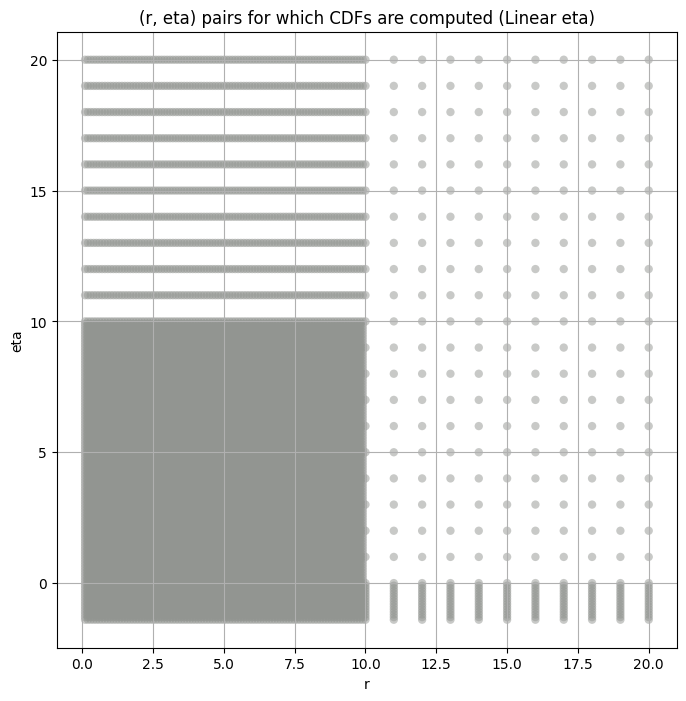

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [10]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [11]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [12]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 29


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,2.232949e+14,2.044359e+14,2.450234e+14,5.252033,2.206041,9.498203,2880.0
5,3.311355e+14,2.838907e+14,3.847795e+14,33.309539,24.537924,41.457803,8640.0
8,6.176871e+13,5.192469e+13,7.556703e+13,52.819935,16.010102,109.145743,24480.0
11,7.202464e+12,6.829576e+12,7.609443e+12,2.392278,1.164339,4.357608,67680.0
14,2.573510e+12,2.321575e+12,2.897079e+12,16.665702,5.415897,35.728051,100000.0
17,3.977914e+14,3.692224e+14,4.292224e+14,6.408159,4.342514,10.709055,100000.0
20,1.329686e+14,1.237109e+14,1.432144e+14,5.945644,3.815722,12.027685,100000.0
23,1.013694e+13,9.443005e+12,1.103544e+13,6.997989,2.698813,24.278620,100000.0
26,3.622786e+12,3.391326e+12,3.881514e+12,4.820236,3.034605,10.719081,100000.0


## Initial Grid Search and Hypothesis Test Plots

In [13]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [14]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,2.232949e+14,2.232949e+14,1.849303e+14,1.693040e+14,1.579378e+14,1.490550e+14,1.343573e+14,1.227693e+14,1.125830e+14,1.038710e+14,9.623687e+13,7.793713e+13
5,3.311355e+14,3.311355e+14,2.464726e+14,2.081746e+14,1.826525e+14,1.657830e+14,1.424461e+14,1.279727e+14,1.194842e+14,1.128666e+14,1.073439e+14,9.454070e+13
8,6.176871e+13,6.176871e+13,5.104397e+13,4.722575e+13,4.454574e+13,4.252157e+13,3.966983e+13,3.781719e+13,3.655366e+13,3.556274e+13,3.471822e+13,3.281465e+13
11,7.202464e+12,7.202464e+12,7.029331e+12,6.935281e+12,6.860580e+12,6.797601e+12,6.691237e+12,6.601169e+12,6.521545e+12,6.449409e+12,6.383534e+12,6.208725e+12
14,2.573510e+12,2.573510e+12,2.395597e+12,2.322677e+12,2.270096e+12,2.227797e+12,2.163017e+12,2.111822e+12,2.068455e+12,2.030550e+12,1.997162e+12,1.913664e+12
17,3.977914e+14,3.977914e+14,3.853929e+14,3.780625e+14,3.720673e+14,3.668636e+14,3.579075e+14,3.502158e+14,3.433980e+14,3.372161e+14,3.314834e+14,3.163707e+14
20,1.329686e+14,1.329686e+14,1.289537e+14,1.266152e+14,1.247037e+14,1.230308e+14,1.201470e+14,1.176641e+14,1.154378e+14,1.134191e+14,1.115586e+14,1.066558e+14
23,1.013694e+13,1.013694e+13,9.754288e+12,9.578502e+12,9.441589e+12,9.325997e+12,9.131633e+12,8.967149e+12,8.822849e+12,8.692765e+12,8.573596e+12,8.262222e+12
26,3.622786e+12,3.622786e+12,3.525808e+12,3.468837e+12,3.421575e+12,3.379958e+12,3.307451e+12,3.244602e+12,3.188419e+12,3.137254e+12,3.090004e+12,2.965444e+12


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.006435636352106977 223294877933040.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.00803657241841893 184930346872837.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.01323112037991403 169303977744107.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.019666199601435896 157937776045468.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.025241412042876776 149055035272965.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.035577618007079675 134357276523423.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.045643279164068296 122769343561330.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.05554383026150267 112582951427877.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.06471131578884962 103871030660596.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07333905778773672 96236871321032.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.09664818161867772 77937134082365.1
Number of samples: 5760, Without approximation : 2880.0


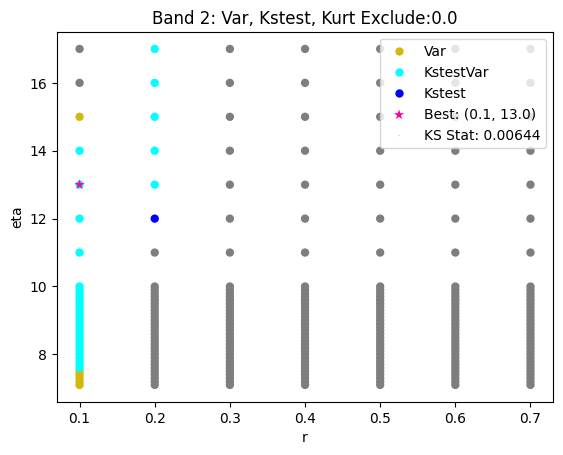

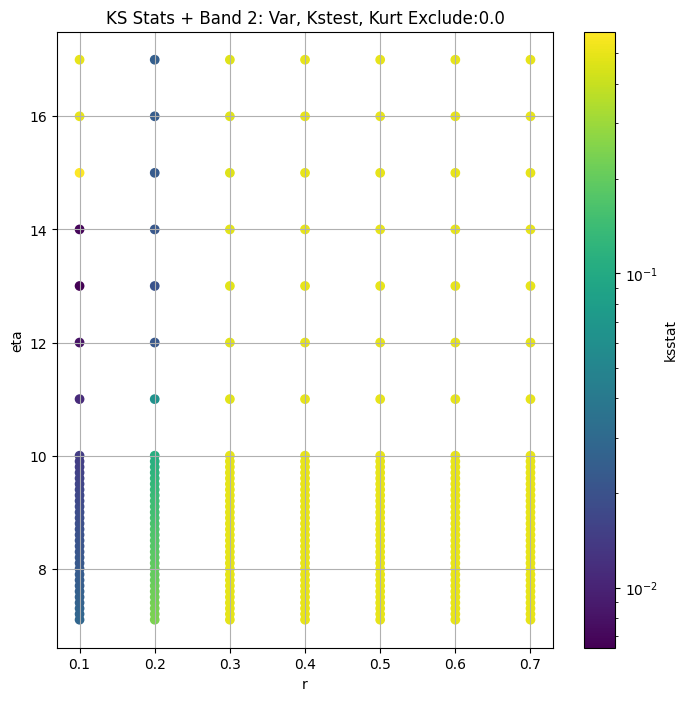

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.02216989823532245 331135490529685.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.017359242646211026 246472640544707.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.012200510395456776 208174611729270.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.00779428145825134 182652546638988.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.008040459695735636 165782964267982.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.009445568378427138 142446099748583.22


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.014820102938021718 127972749046771.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.017775897094628124 119484248784928.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.020524052162476325 112866590594546.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.023455319382835182 107343889676061.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03393065054249311 94540703909626.25
Number of samples: 17280, Without approximation : 8640.0


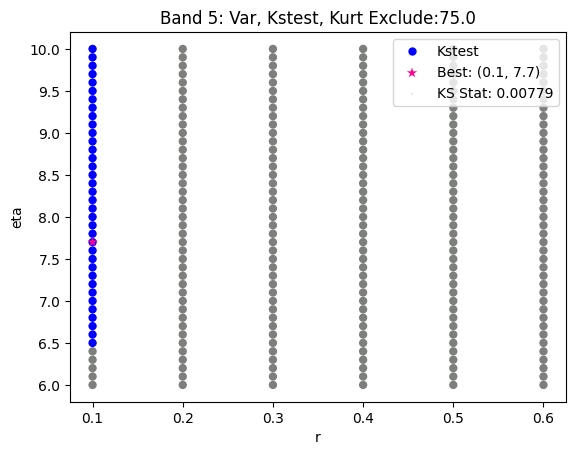

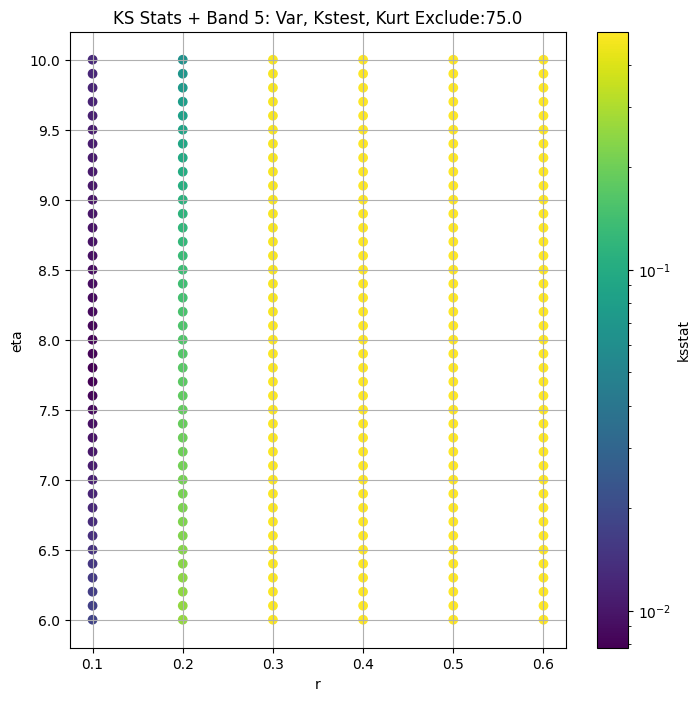

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.008817920830259451 61768711805751.805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.008817920830259451 51043968520616.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.008817920830259451 47225752352399.93


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.008817920830259451 44545741170319.07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.006789107244250511 42521565501937.79


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.004621812188610141 39669827682244.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.005290450681945669 37817191141712.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0062742964526995015 36553655989533.09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.008879314340004052 35562742874269.71


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01148699928926944 34718221075586.58


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.0176790419211659 32814653078598.617
Number of samples: 48960, Without approximation : 24480.0


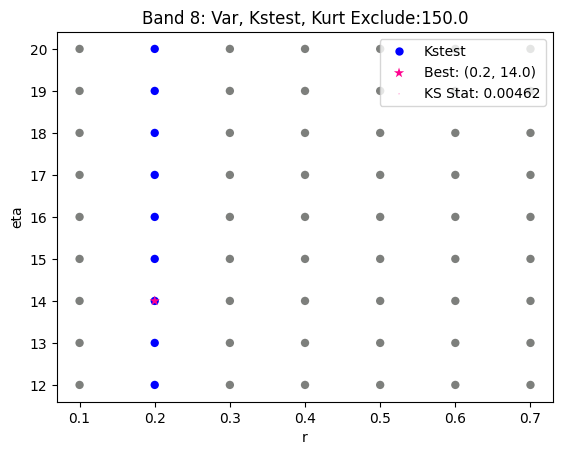

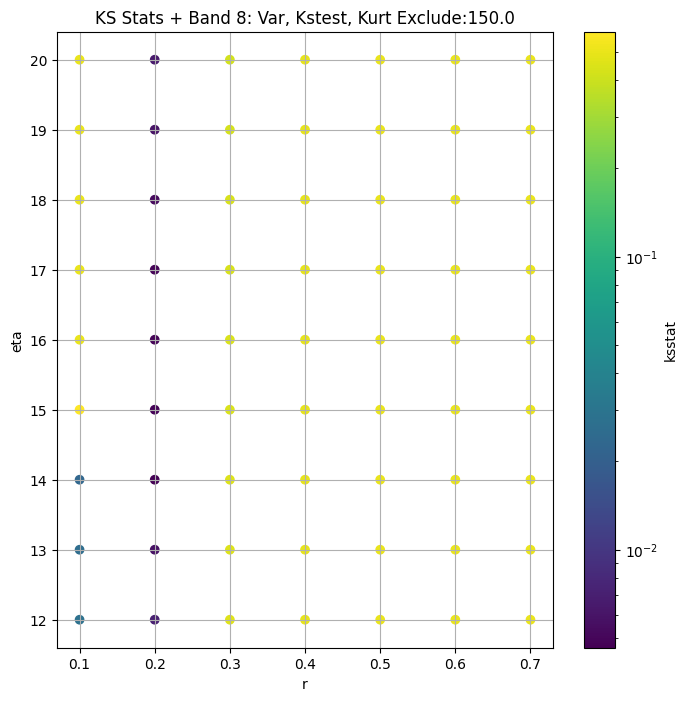

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.0037401331068231958 7202463999581.788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.00230444462797208 7029331314997.503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.001516762754274037 6935281234602.702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.001390630387211822 6860580033253.085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.002296723092397479 6797600982517.578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0038518021598046848 6691236874937.229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.005214930464381373 6601169271452.904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.006574455723633077 6521545084247.047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.007822323136337156 6449409325276.277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.008975629772661115 6383533671897.699


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.0121015248090868 6208724880508.037
Number of samples: 100000, Without approximation : 67680.0


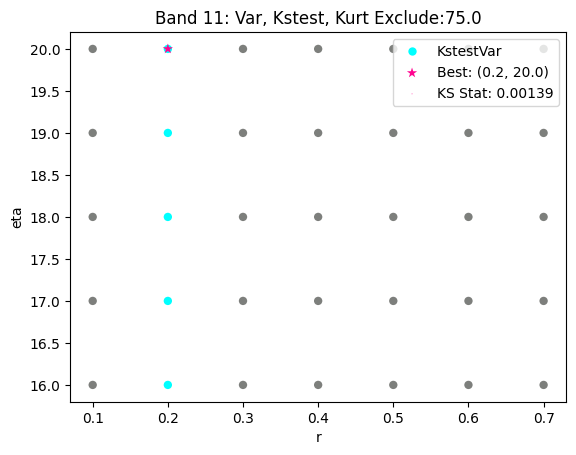

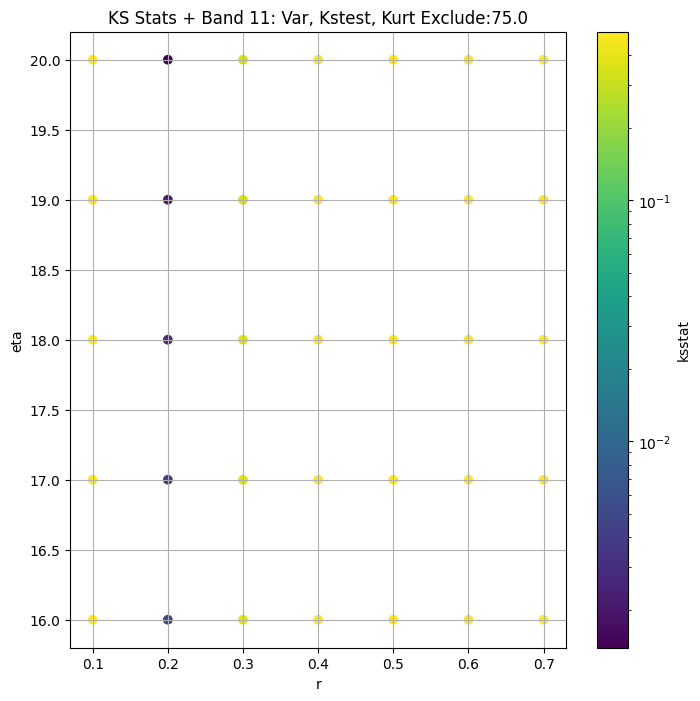

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.008181969925448174 2573510235403.665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.005714710027693415 2395597348081.442


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.004220802386640798 2322677492393.7993


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.003319728528077326 2270096454672.4785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.0025568119893445984 2227796633321.8823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.002342164095513603 2163017018989.002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.002689940727653144 2111822138306.9368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.0031004210462179573 2068454653099.5295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.0038226454956189933 2030550123352.1526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.004590581277021499 1997162350198.226


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.006616665996802572 1913664188244.2122
Number of samples: 100000, Without approximation : 100000.0


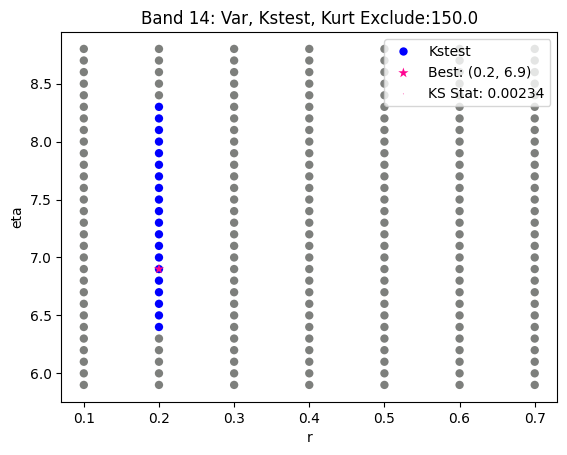

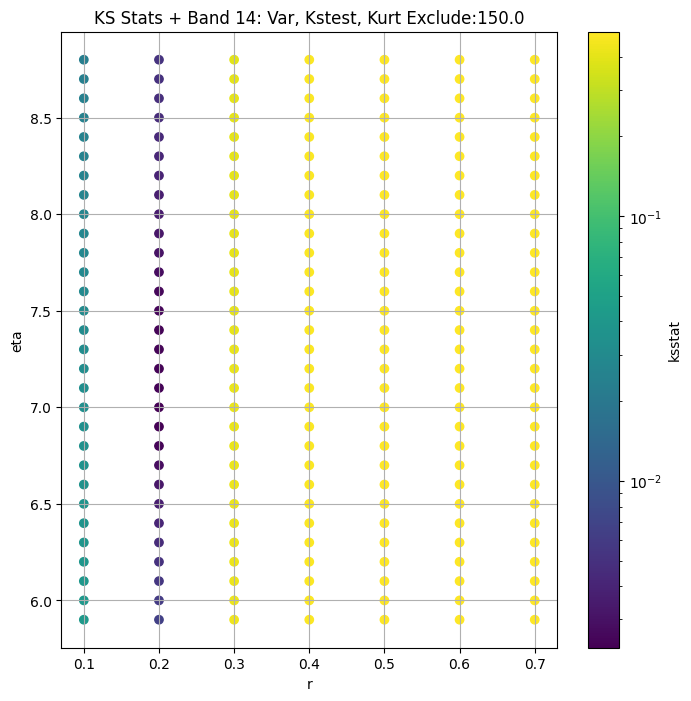

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.012622534463042068 397791423435256.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.013431146042898412 385392940384386.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.013641904478850275 378062519938139.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.014036449332625725 372067283578017.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.014416846994026386 366863569955563.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.015046202093369265 357907469949307.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.015874294077285356 350215833213264.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.016355977687745826 343397951352928.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.016682610072313295 337216143682700.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.017447079100404314 331483421070278.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.018786055726593198 316370657923909.56
Number of samples: 100000, Without approximation : 100000.0


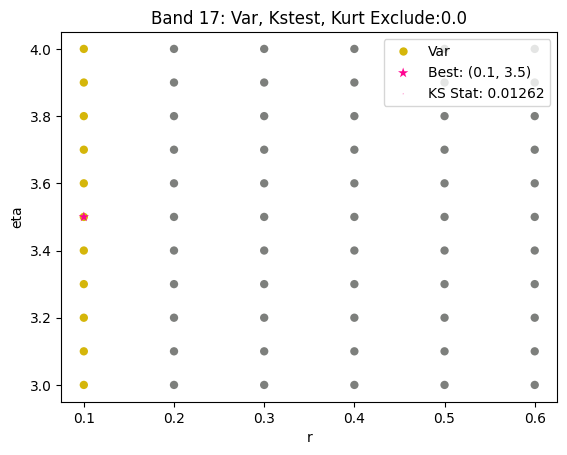

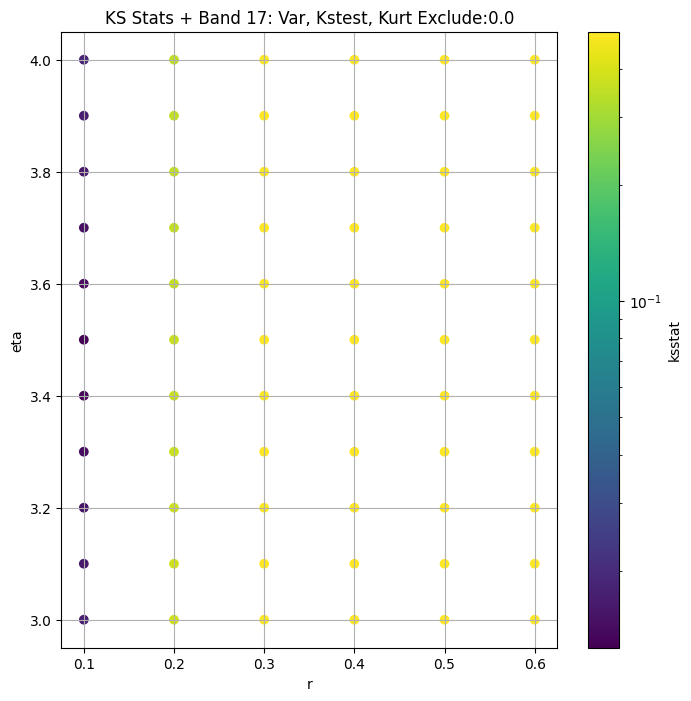

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0012432332089646059 132968564675201.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0023006405209918604 128953736181156.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.002986578251609112 126615176170519.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0036333502912594823 124703676055662.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.004111092059244842 123030813560069.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.005038998240431226 120146978022180.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.005920551411042127 117664069977181.45


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.006695278818945653 115437776191772.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.007430438885248761 113419106209487.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.008140675129913948 111558578728718.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.010201401263142812 106655807602178.05
Number of samples: 100000, Without approximation : 100000.0


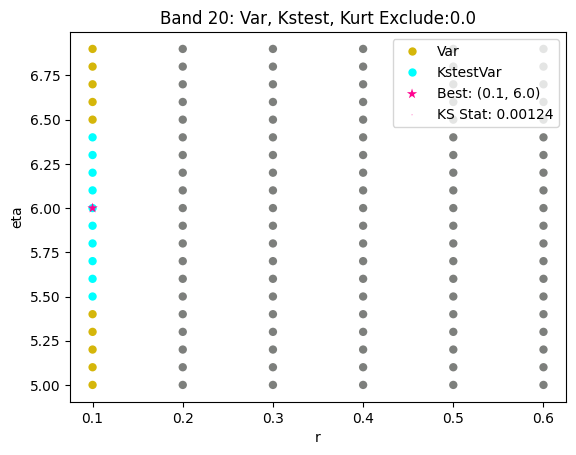

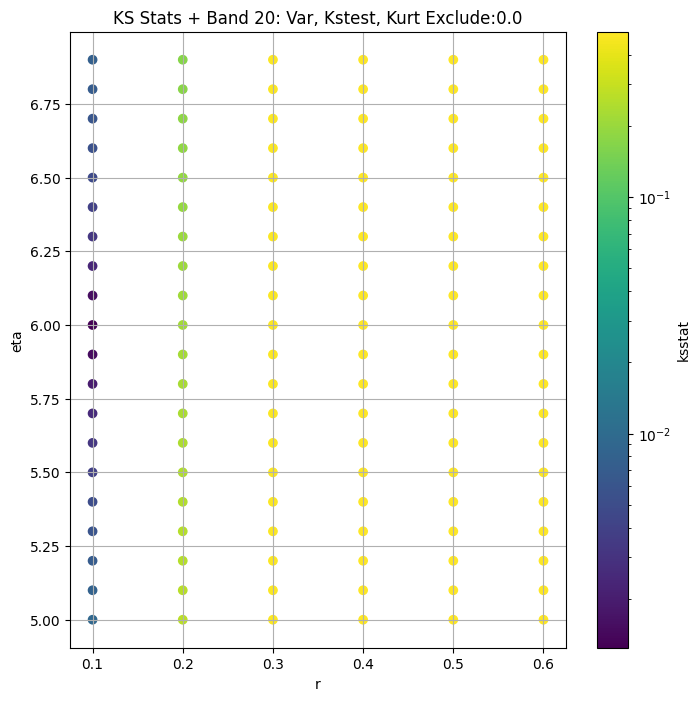

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.001010829093082366 10136939875120.775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.001010829093082366 9754287603054.826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0009655979079263646 9578501784633.865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0012534842249551925 9441589135893.066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0015135447822132598 9325996580737.111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0023043506004468348 9131632550593.018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.003263169281412265 8967148540690.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004135484445524952 8822848656046.346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.0049538129192291044 8692764638697.326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.005729592099928349 8573596261424.467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.007879621450881745 8262222198735.326
Number of samples: 100000, Without approximation : 100000.0


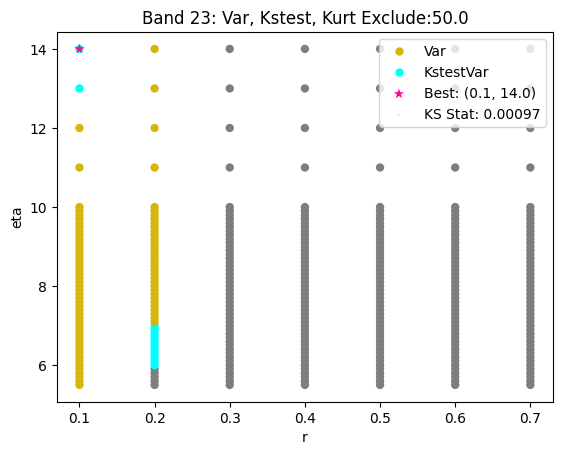

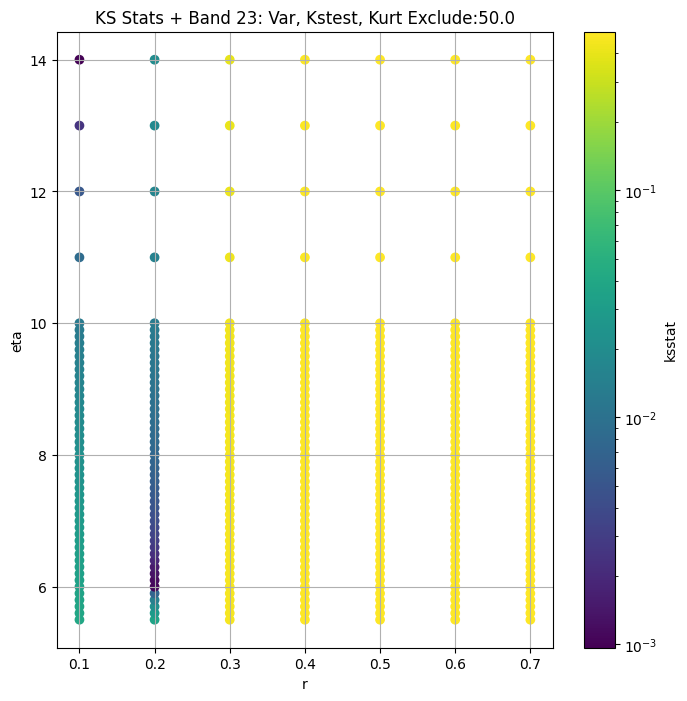

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.001569197765799224 3622786470302.1504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0011130645863226436 3525807699125.4424


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0016868763712620527 3468836656901.238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0022594199302401925 3421574522073.033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.002783736495858821 3379958305091.0693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.003454951329135831 3307450780111.3306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.0043161911396905756 3244601766535.049


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005140806390593083 3188418936124.737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.005921629611500327 3137253707974.2866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006670074334114692 3090004375942.5923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.008774916451850197 2965443822582.96
Number of samples: 100000, Without approximation : 100000.0


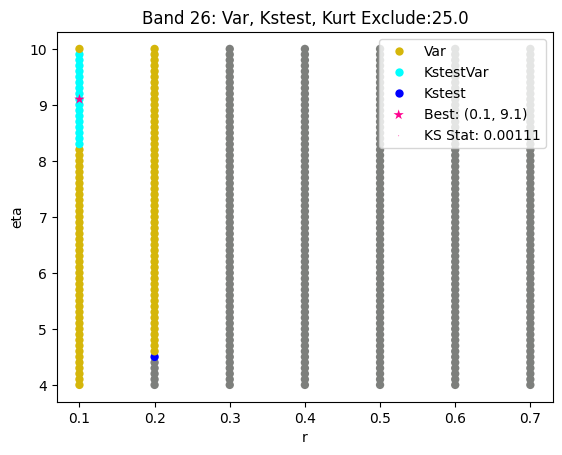

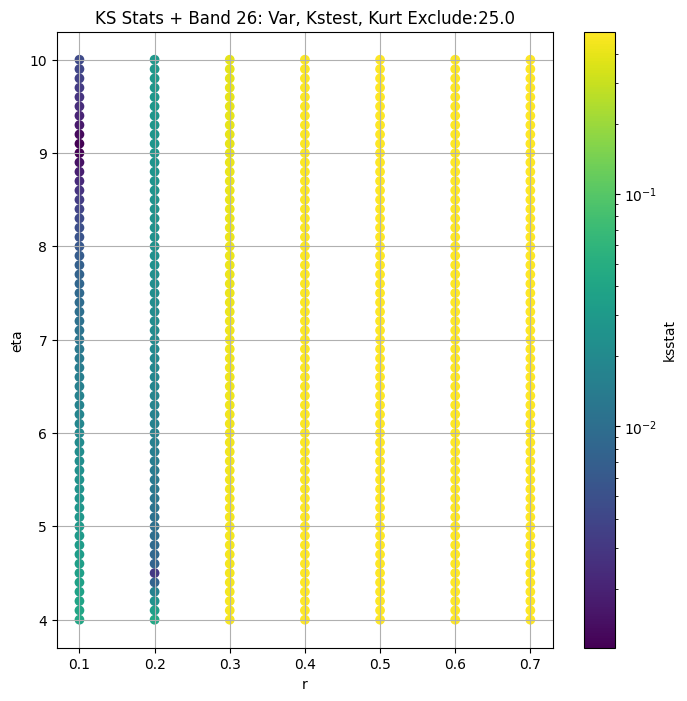

####
Band  29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 0 0.0015914430398400042 105325354751.27403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 25 0.0020861217375117286 102148910989.81253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 50 0.0027844553296947627 100331466621.46114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 75 0.0033111208511569443 98819921809.43993


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 100 0.0038447458045653554 97488034870.92178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 150 0.004803415328731846 95168502967.02792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 200 0.005672430737986012 93154698228.11374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 250 0.006484475178901279 91352729128.41017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 300 0.00722248747562354 89709565763.34467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 350 0.007965926538018926 88191349366.31207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 500 0.010043820931789314 84190929131.41878
Number of samples: 100000, Without approximation : 100000.0


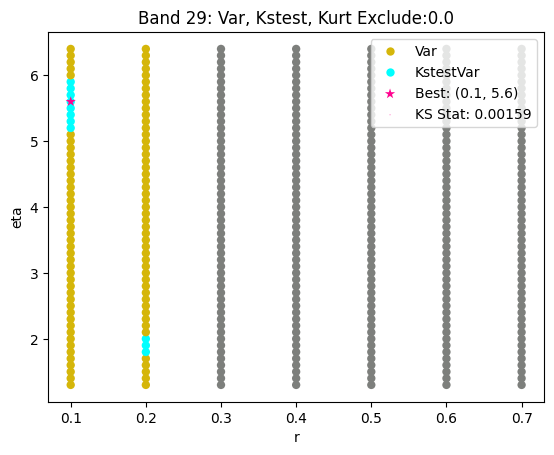

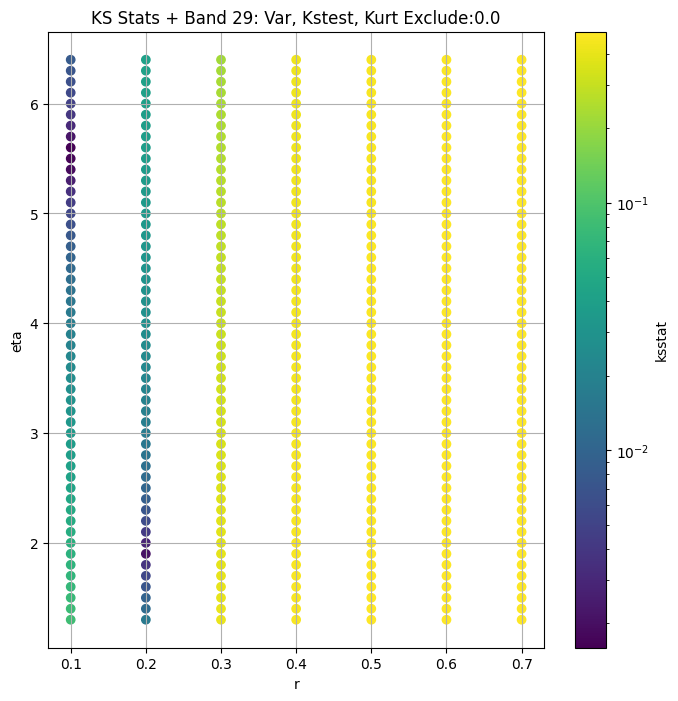

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,2.232949e+14,2.044359e+14,2.450234e+14,5.252033,2.206041,9.498203,2880.0,0.006436,0.1,13.0,4.011148e-08,0.0,2.232949e+14,0.025248
5,3.311355e+14,2.838907e+14,3.847795e+14,33.309539,24.537924,41.457803,8640.0,0.007794,0.1,7.7,2.619859e-06,75.0,1.826525e+14,0.014591
8,6.176871e+13,5.192469e+13,7.556703e+13,52.819935,16.010102,109.145743,24480.0,0.004622,0.2,14.0,1.250168e+04,150.0,3.966983e+13,0.008673
11,7.202464e+12,6.829576e+12,7.609443e+12,2.392278,1.164339,4.357608,67680.0,0.001391,0.2,20.0,4.359848e+02,75.0,6.860580e+12,0.005218
14,2.573510e+12,2.321575e+12,2.897079e+12,16.665702,5.415897,35.728051,100000.0,0.002342,0.2,6.9,1.314980e+04,150.0,2.163017e+12,0.004293
17,3.977914e+14,3.692224e+14,4.292224e+14,6.408159,4.342514,10.709055,100000.0,0.012623,0.1,3.5,1.744764e-03,0.0,3.977914e+14,0.004293
20,1.329686e+14,1.237109e+14,1.432144e+14,5.945644,3.815722,12.027685,100000.0,0.001243,0.1,6.0,1.327136e-05,0.0,1.329686e+14,0.004293
23,1.013694e+13,9.443005e+12,1.103544e+13,6.997989,2.698813,24.278620,100000.0,0.000966,0.1,14.0,9.003163e-10,50.0,9.578502e+12,0.004293
26,3.622786e+12,3.391326e+12,3.881514e+12,4.820236,3.034605,10.719081,100000.0,0.001113,0.1,9.1,1.303479e-08,25.0,3.525808e+12,0.004293


In [15]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [16]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.029862337728480737, var: 149055035272965.84


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.023416046112230637, var: 157937776045468.38


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.01570358893286683, var: 169303977744107.5


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.007988289246132818, var: 184930346872837.28


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.006435636352106977, var: 223294877933040.12
Number of samples: 5760, Without approximation : 2880.0


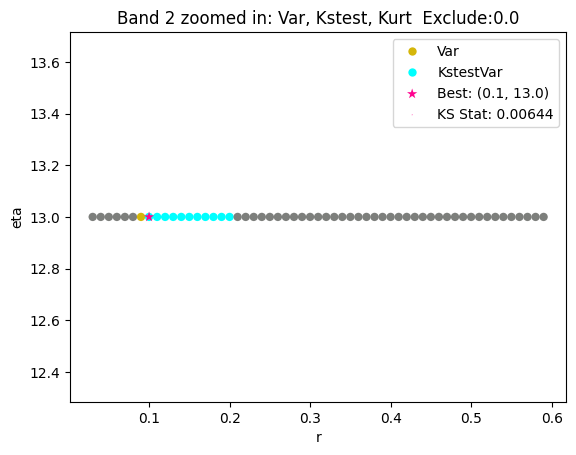

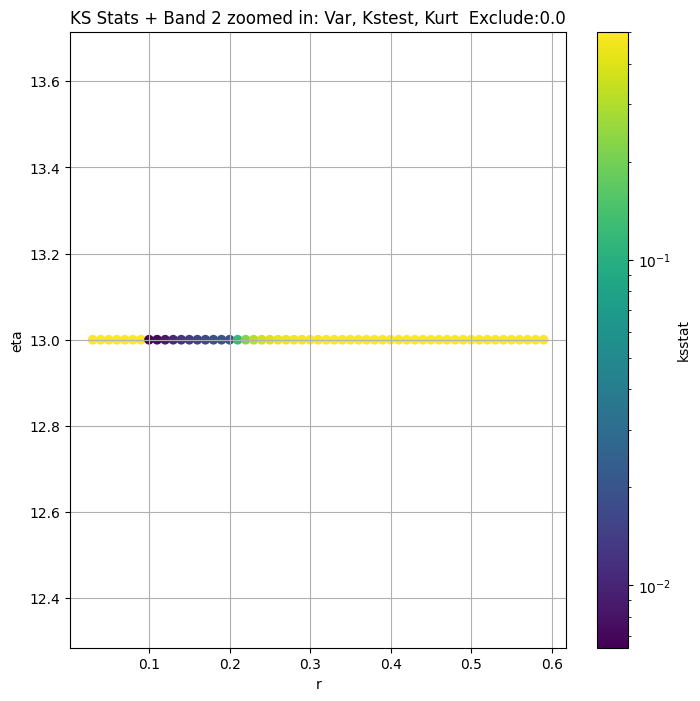

Band 5


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.011655859804893899, var: 134127391115000.44


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.009289940437465786, var: 142446099748583.22


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.008685950402163911, var: 152691117619861.9


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.0080452258000547, var: 165782964267982.47


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.00779428145825134, var: 182652546638988.84


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.012040288761390974, var: 208174611729270.56


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.0181950745241444, var: 246472640544707.56


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.0181950745241444, var: 331135490529685.9
Number of samples: 17280, Without approximation : 8640.0


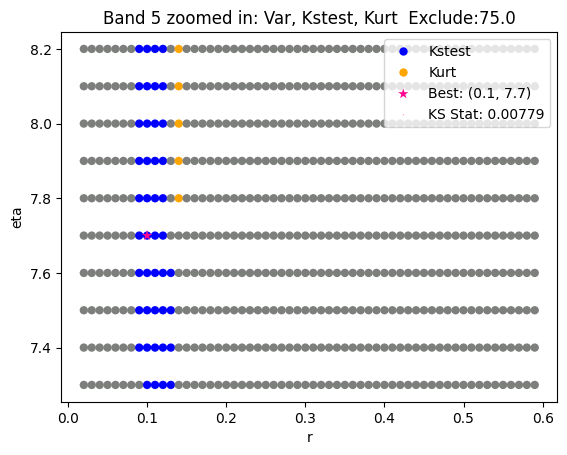

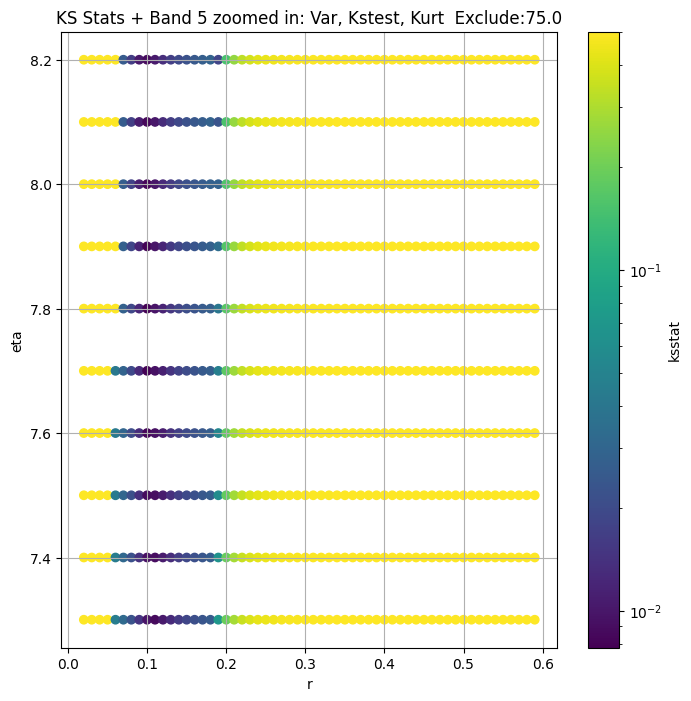

Band 8


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + 100 = 250, ksstat: 0.010791891278179588, var: 36553655989533.09


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + 75 = 225, ksstat: 0.009306179701760176, var: 37125705864874.05


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + 50 = 200, ksstat: 0.007620927768385188, var: 37817191141712.9


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + 25 = 175, ksstat: 0.005776440997471488, var: 38657227710388.37


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + 0 = 150, ksstat: 0.004621812188610141, var: 39669827682244.55


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + -25 = 125, ksstat: 0.004960787768289565, var: 40919559342460.39


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + -50 = 100, ksstat: 0.006690658886638112, var: 42521565501937.79


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + -75 = 75, ksstat: 0.009270088877968763, var: 44545741170319.07


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 8, 150.0 + -100 = 50, ksstat: 0.012203219322626802, var: 47225752352399.93
Number of samples: 48960, Without approximation : 24480.0


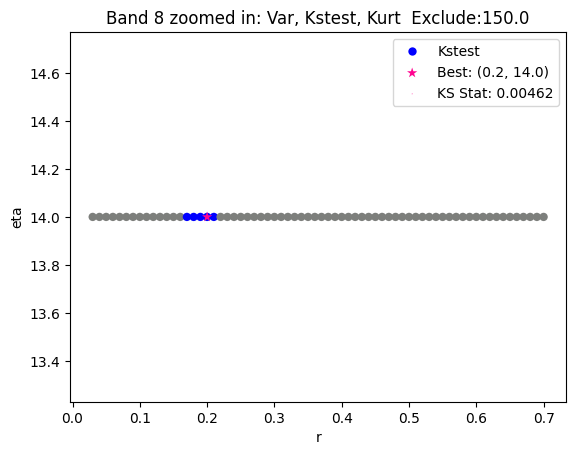

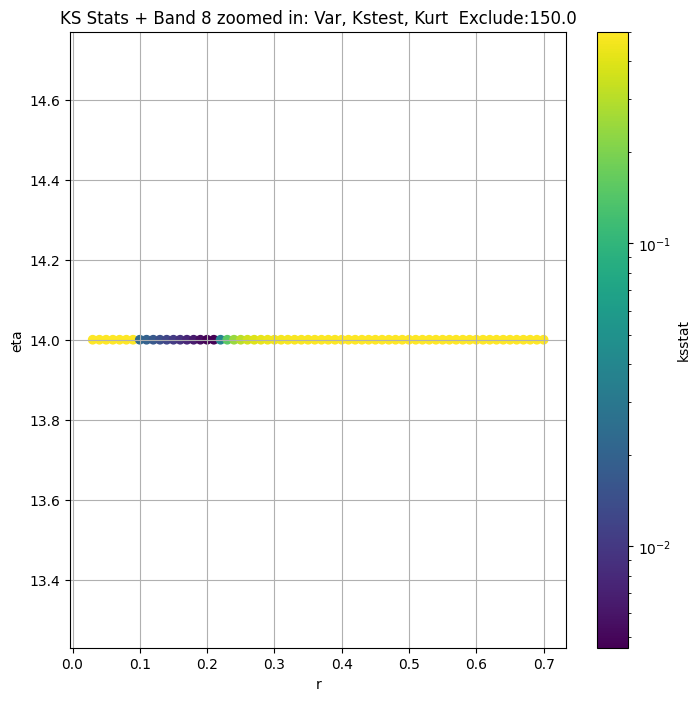

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 100 = 175, ksstat: 0.0024520584063049133, var: 6644378606401.183


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 75 = 150, ksstat: 0.002094085329108616, var: 6691236874937.229


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 50 = 125, ksstat: 0.001838648779954018, var: 6742292239949.253


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 25 = 100, ksstat: 0.001604410340013851, var: 6797600982517.578


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + 0 = 75, ksstat: 0.0013713822691029057, var: 6860580033253.085


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -25 = 50, ksstat: 0.0014935698453488744, var: 6935281234602.702


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -50 = 25, ksstat: 0.002218317874257969, var: 7029331314997.503


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 75.0 + -75 = 0, ksstat: 0.003691602523351989, var: 7202463999581.788
Number of samples: 100000, Without approximation : 67680.0


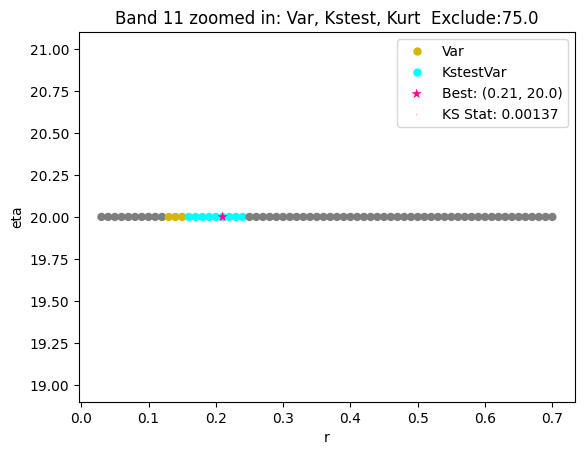

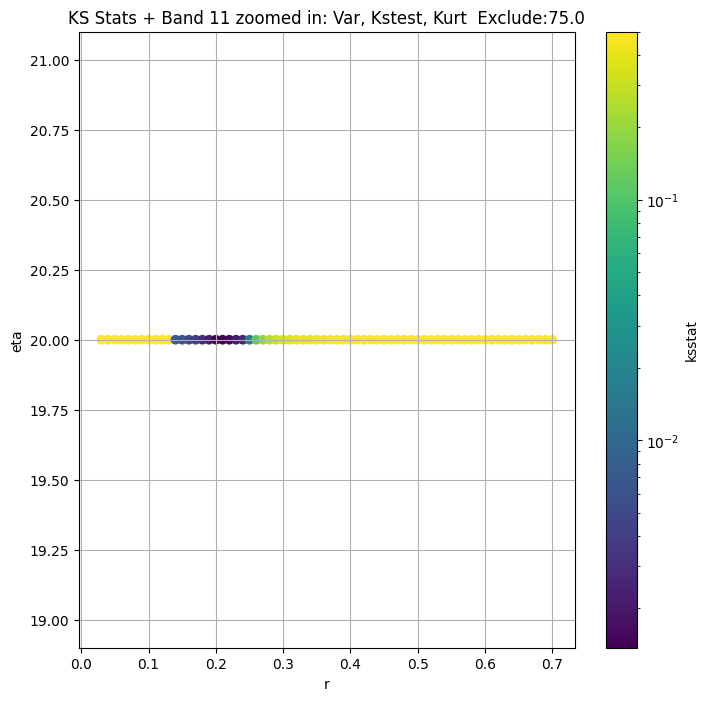

Band 14


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + 100 = 250, ksstat: 0.003127888929230627, var: 2068454653099.5295


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + 75 = 225, ksstat: 0.002888767207804975, var: 2089293946983.705


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + 50 = 200, ksstat: 0.002703749255096323, var: 2111822138306.9368


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + 25 = 175, ksstat: 0.0025097665916830494, var: 2136298853190.9182


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + 0 = 150, ksstat: 0.0023222625380840125, var: 2163017018989.002


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + -25 = 125, ksstat: 0.002283051209873599, var: 2193094189584.545


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + -50 = 100, ksstat: 0.0028492387959150323, var: 2227796633321.8823


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + -75 = 75, ksstat: 0.0028997509640328687, var: 2270096454672.4785


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 14, 150.0 + -100 = 50, ksstat: 0.0028997509640328687, var: 2322677492393.7993
Number of samples: 100000, Without approximation : 100000.0


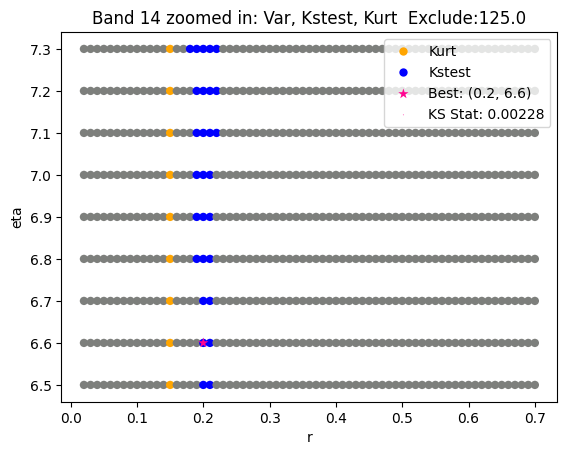

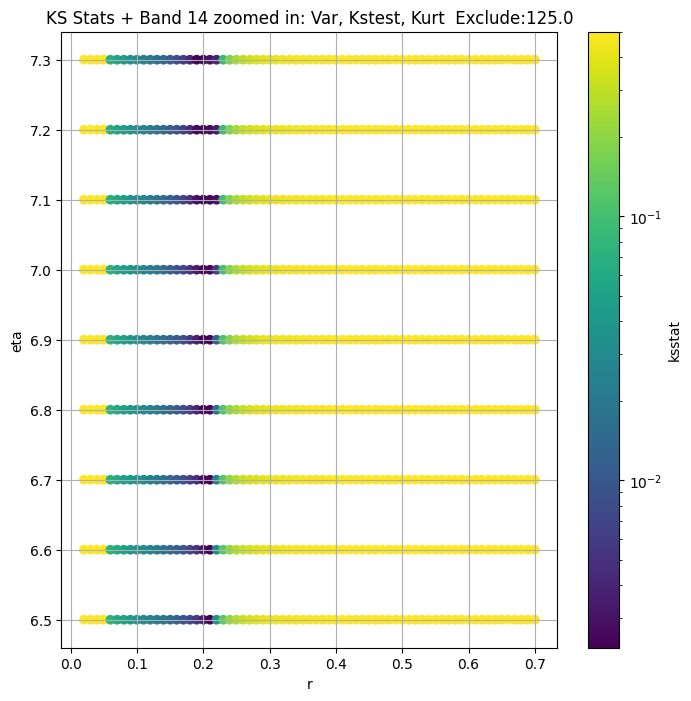

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.014370403206361626, var: 366863569955563.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.013929495782616819, var: 372067283578017.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.013525103350067402, var: 378062519938139.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.013208900617004304, var: 385392940384386.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.012622534463042068, var: 397791423435256.9
Number of samples: 100000, Without approximation : 100000.0


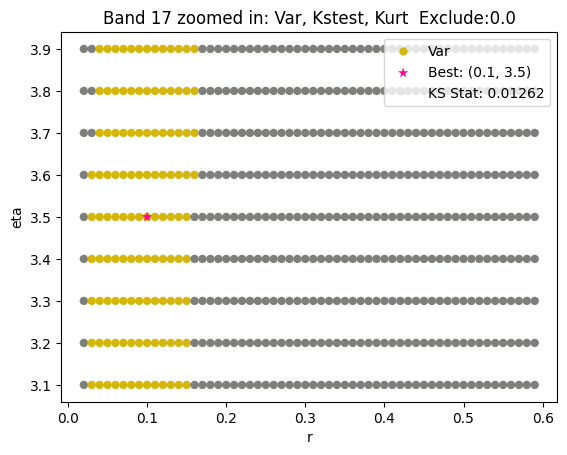

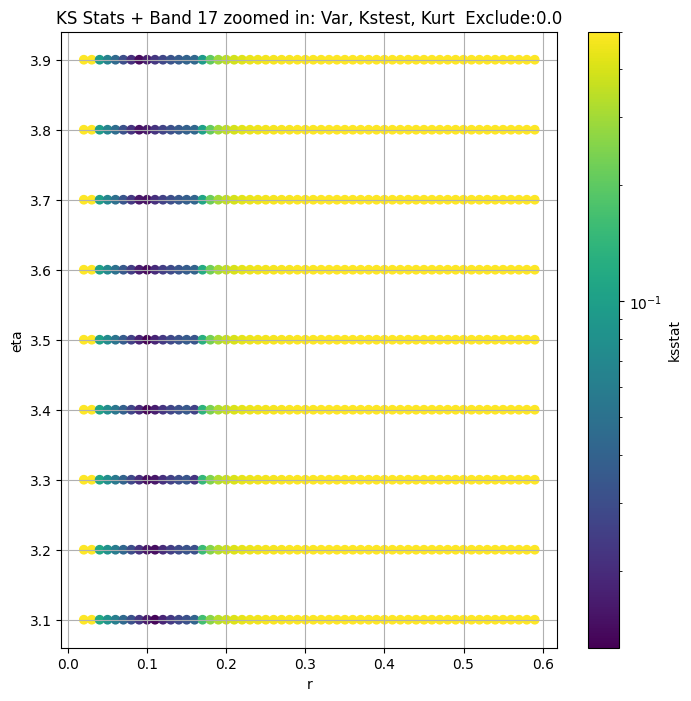

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 0.0 + 100 = 100, ksstat: 0.003972248191484153, var: 123030813560069.77


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 0.0 + 75 = 75, ksstat: 0.003432856873551368, var: 124703676055662.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 0.0 + 50 = 50, ksstat: 0.002934196094060558, var: 126615176170519.38


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 0.0 + 25 = 25, ksstat: 0.0022833520193181953, var: 128953736181156.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 0.0 + 0 = 0, ksstat: 0.0012432332089646059, var: 132968564675201.31
Number of samples: 100000, Without approximation : 100000.0


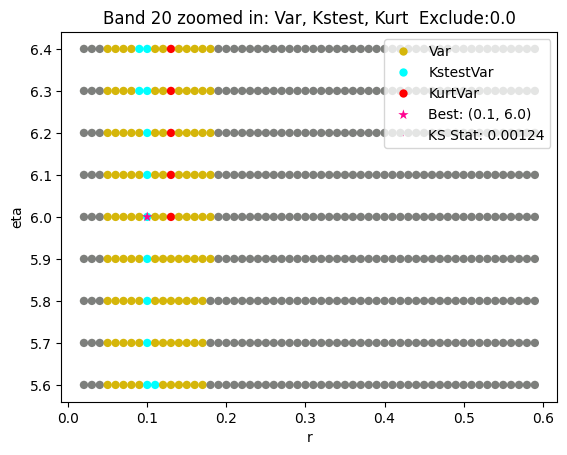

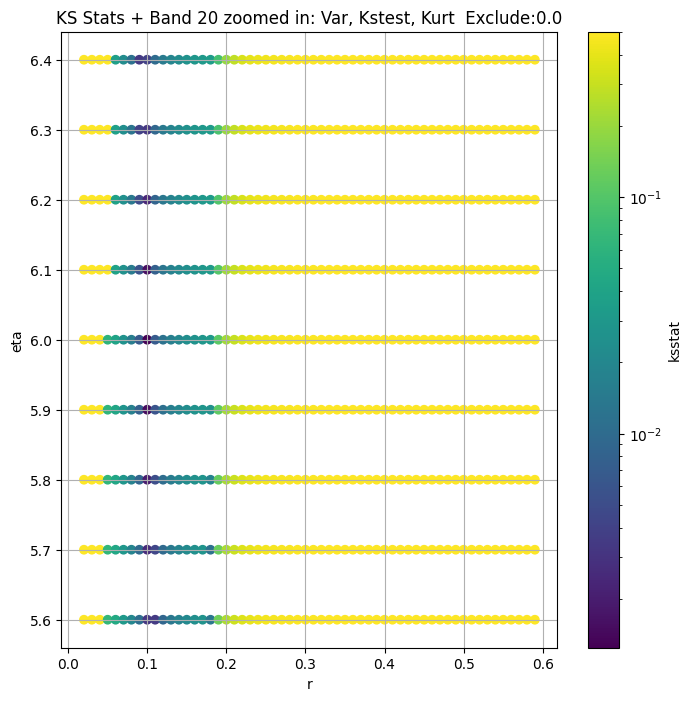

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.002496170992607266, var: 9131632550593.018


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.0020820973005709134, var: 9223921824376.264


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.0017472281026312785, var: 9325996580737.111


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0012915186664161915, var: 9441589135893.066


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.0009655979079263646, var: 9578501784633.865


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.0025779155752256866, var: 9754287603054.826


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.0066222678009522085, var: 10136939875120.775
Number of samples: 100000, Without approximation : 100000.0


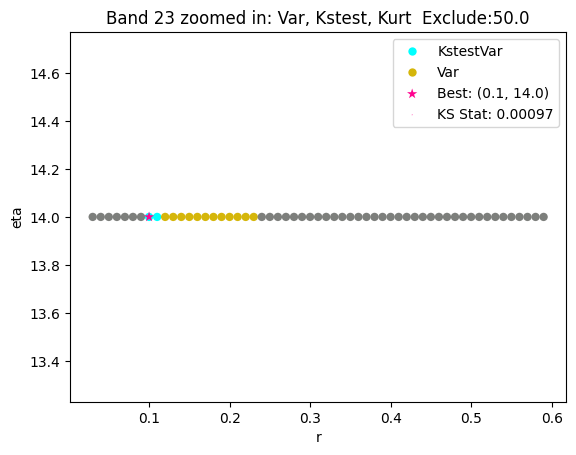

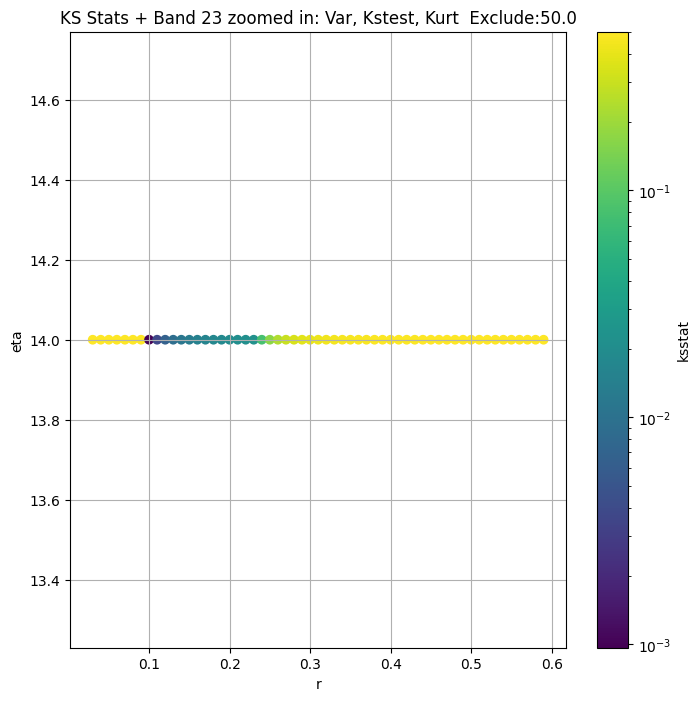

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.0032193439793180394, var: 3342219455809.7197


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.002749312463584612, var: 3379958305091.0693


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.002227373761038376, var: 3421574522073.033


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0016868763712620527, var: 3468836656901.238


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.0011130645863226436, var: 3525807699125.4424


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.0018976579957334372, var: 3622786470302.1504
Number of samples: 100000, Without approximation : 100000.0


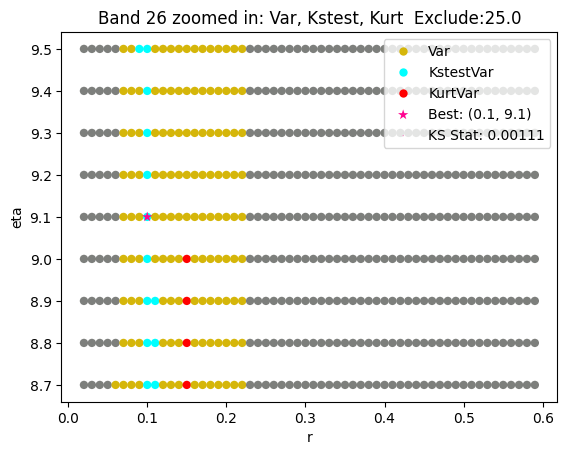

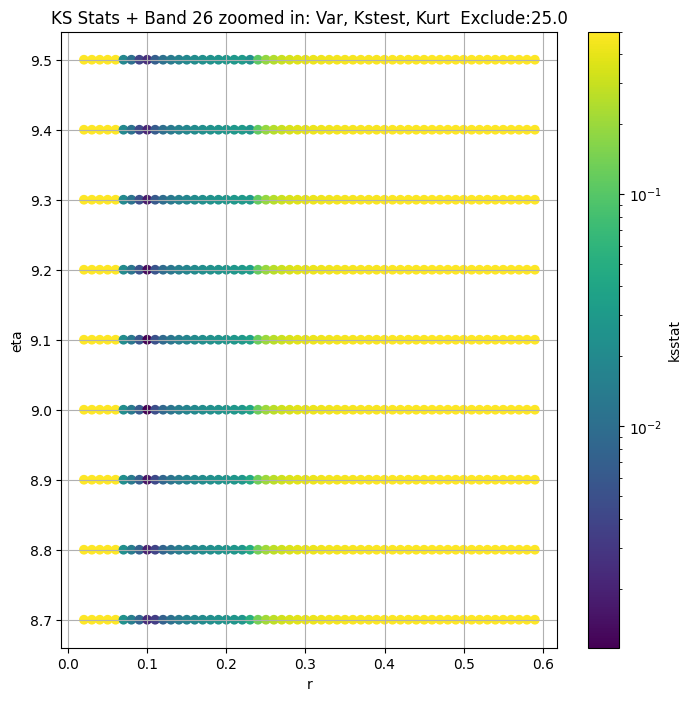

Band 29


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 0.0 + 100 = 100, ksstat: 0.004295219257714256, var: 97488034870.92178


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 0.0 + 75 = 75, ksstat: 0.003732840338009469, var: 98819921809.43993


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 0.0 + 50 = 50, ksstat: 0.0032324724154468715, var: 100331466621.46114


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 0.0 + 25 = 25, ksstat: 0.0026142818946002233, var: 102148910989.81253


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 29, 0.0 + 0 = 0, ksstat: 0.0015914430398400042, var: 105325354751.27403
Number of samples: 100000, Without approximation : 100000.0


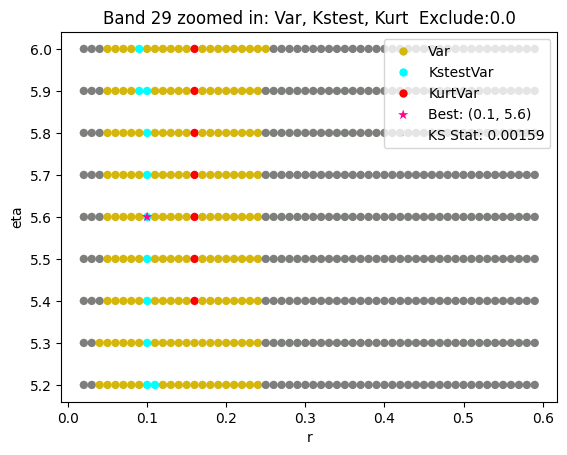

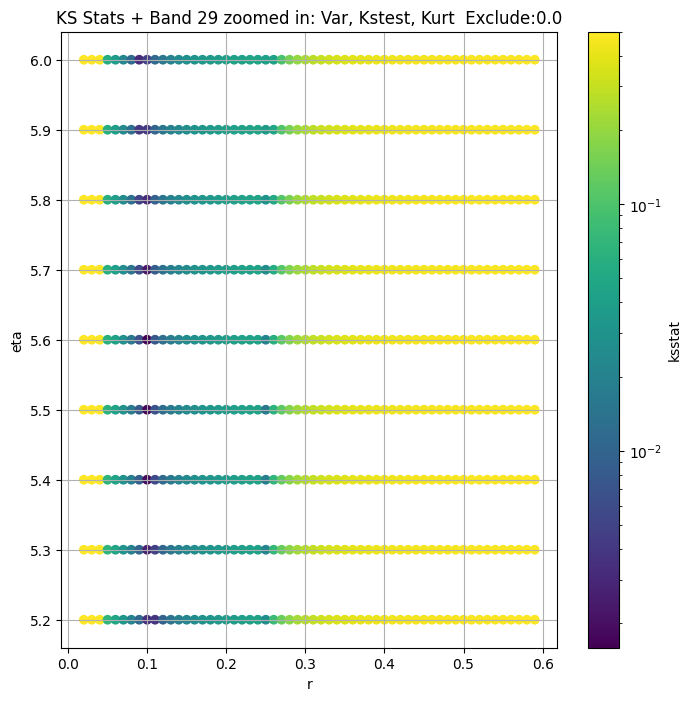

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,2.232949e+14,2.044359e+14,2.450234e+14,5.252033,2.206041,9.498203,2880.0,0.006436,0.1,13.0,4.011148e-08,0.0,2.232949e+14,0.025248,0.006436,0.10,13.0,4.011148e-08,0.0,46705
5,3.311355e+14,2.838907e+14,3.847795e+14,33.309539,24.537924,41.457803,8640.0,0.007794,0.1,7.7,2.619859e-06,75.0,1.826525e+14,0.014591,0.007794,0.10,7.7,2.619859e-06,75.0,29160
8,6.176871e+13,5.192469e+13,7.556703e+13,52.819935,16.010102,109.145743,24480.0,0.004622,0.2,14.0,1.250168e+04,150.0,3.966983e+13,0.008673,0.004622,0.20,14.0,1.250168e+04,150.0,82620
11,7.202464e+12,6.829576e+12,7.609443e+12,2.392278,1.164339,4.357608,67680.0,0.001391,0.2,20.0,4.359848e+02,75.0,6.860580e+12,0.005218,0.001371,0.21,20.0,1.684265e+03,75.0,975690
14,2.573510e+12,2.321575e+12,2.897079e+12,16.665702,5.415897,35.728051,100000.0,0.002342,0.2,6.9,1.314980e+04,150.0,2.193094e+12,0.004293,0.002283,0.20,6.6,1.586047e+04,125.0,337500
17,3.977914e+14,3.692224e+14,4.292224e+14,6.408159,4.342514,10.709055,100000.0,0.012623,0.1,3.5,1.744764e-03,0.0,3.977914e+14,0.004293,0.012623,0.10,3.5,1.744764e-03,0.0,11863
20,1.329686e+14,1.237109e+14,1.432144e+14,5.945644,3.815722,12.027685,100000.0,0.001243,0.1,6.0,1.327136e-05,0.0,1.329686e+14,0.004293,0.001243,0.10,6.0,1.327136e-05,0.0,1139062
23,1.013694e+13,9.443005e+12,1.103544e+13,6.997989,2.698813,24.278620,100000.0,0.000966,0.1,14.0,9.003163e-10,50.0,9.578502e+12,0.004293,0.000966,0.10,14.0,9.003163e-10,50.0,1922166
26,3.622786e+12,3.391326e+12,3.881514e+12,4.820236,3.034605,10.719081,100000.0,0.001113,0.1,9.1,1.303479e-08,25.0,3.525808e+12,0.004293,0.001113,0.10,9.1,1.303479e-08,25.0,1441624


In [17]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

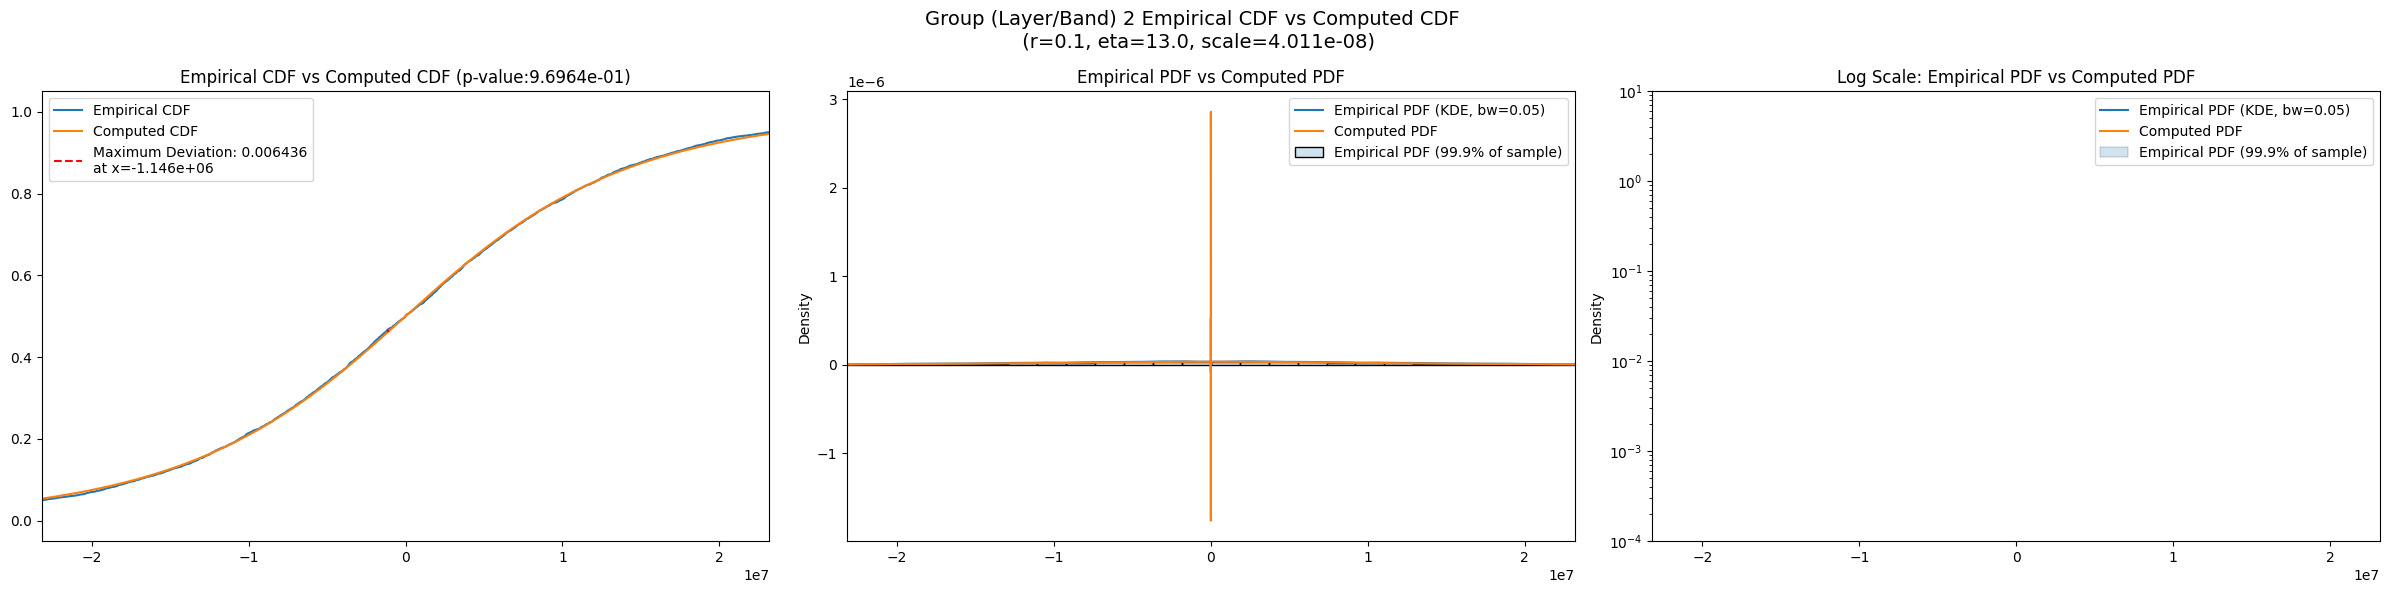

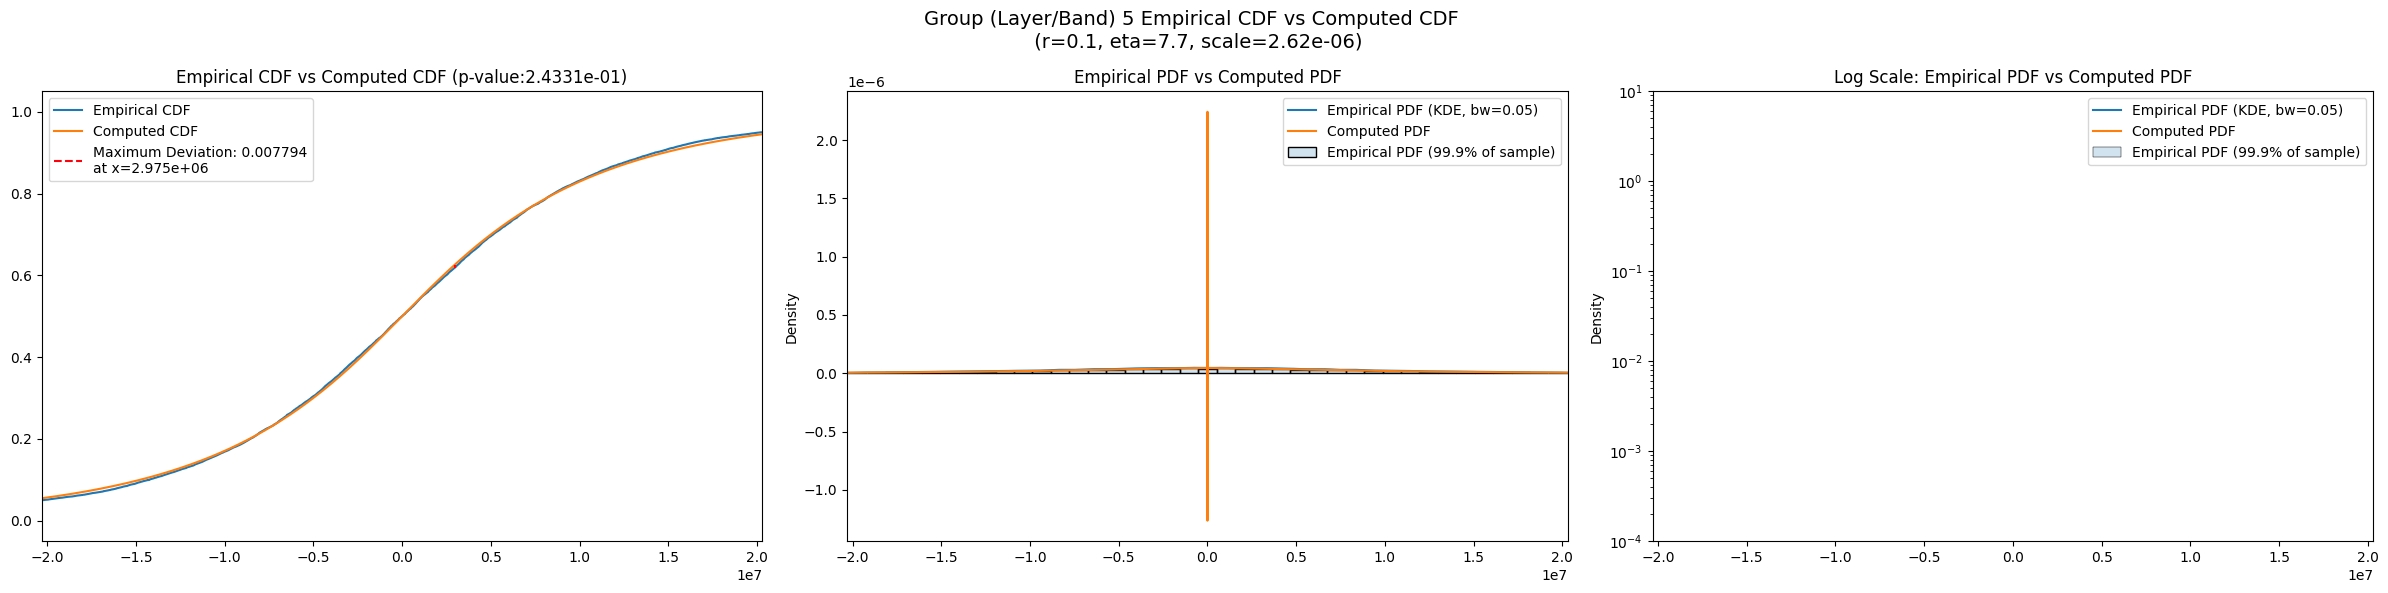

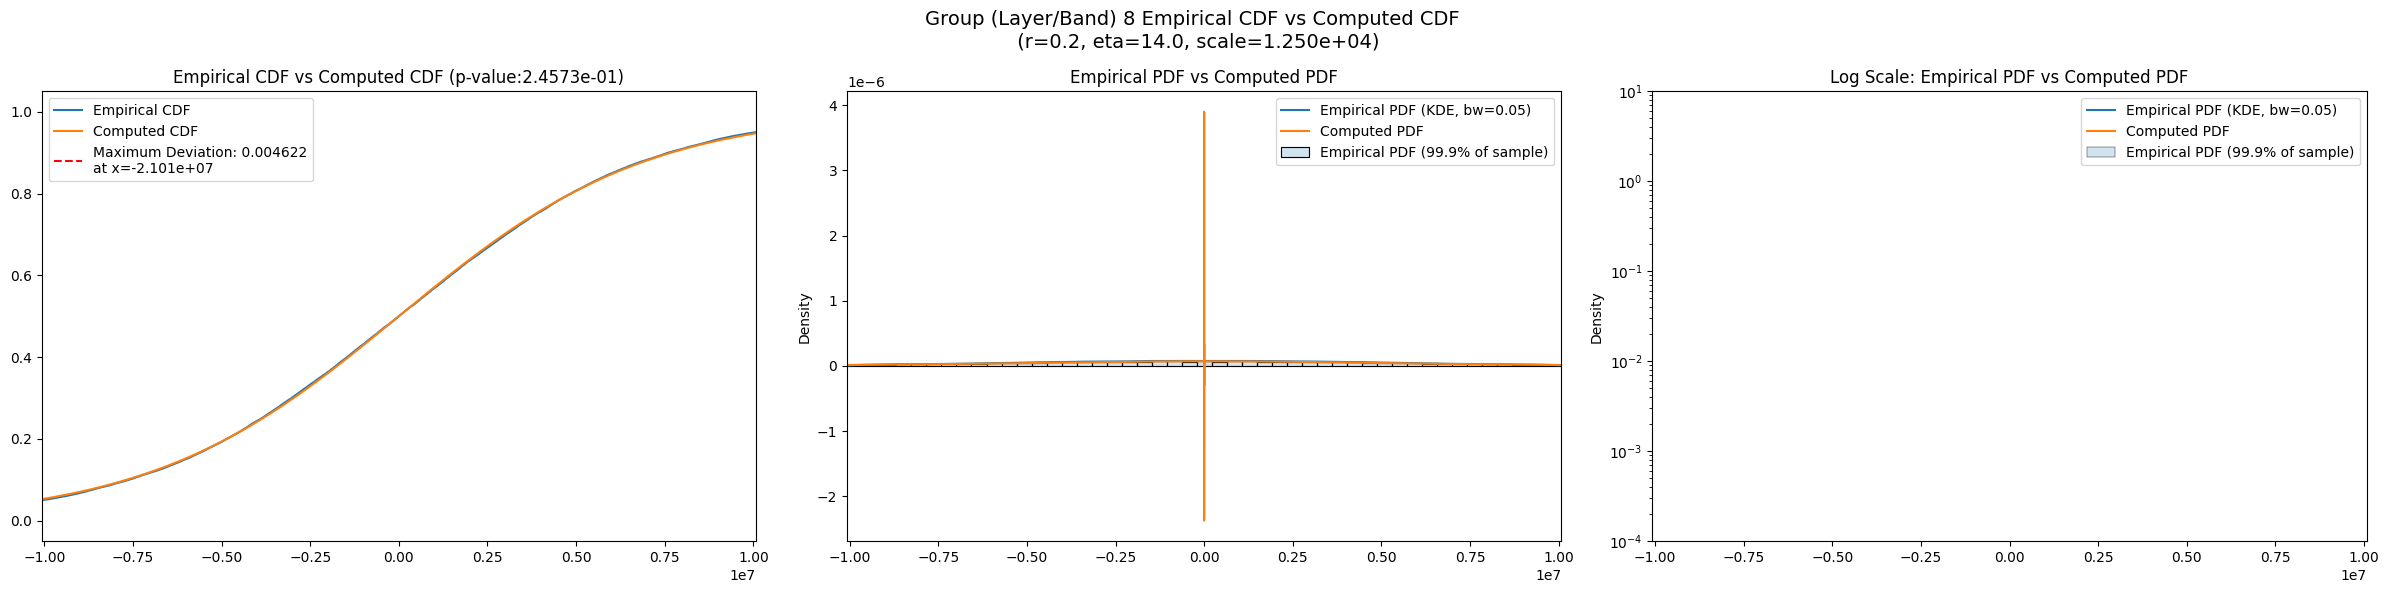

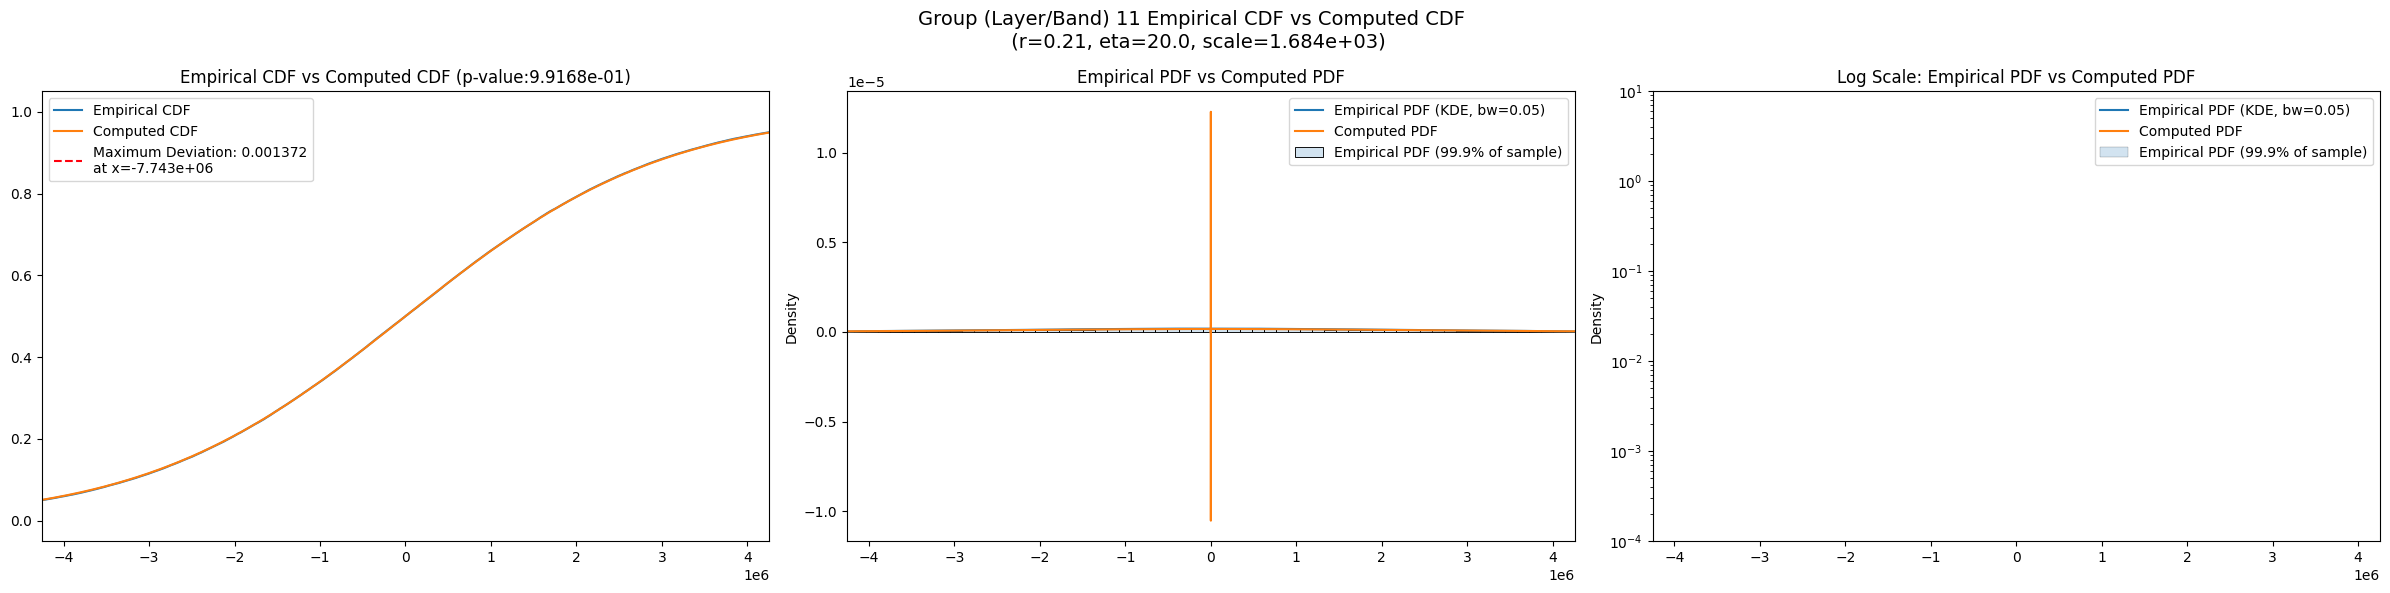

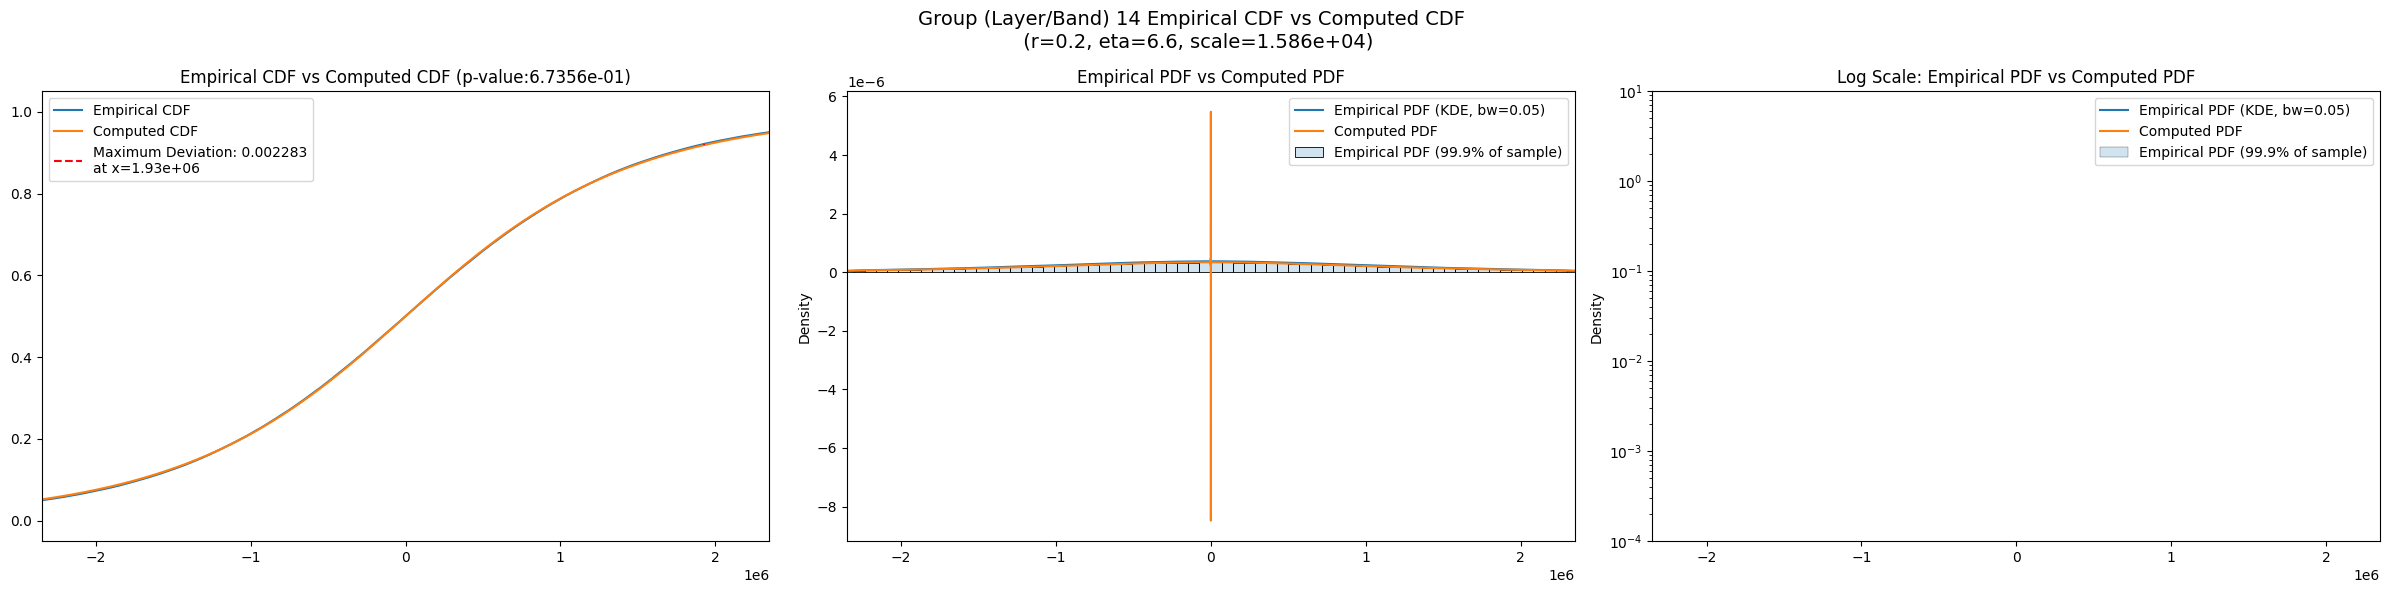

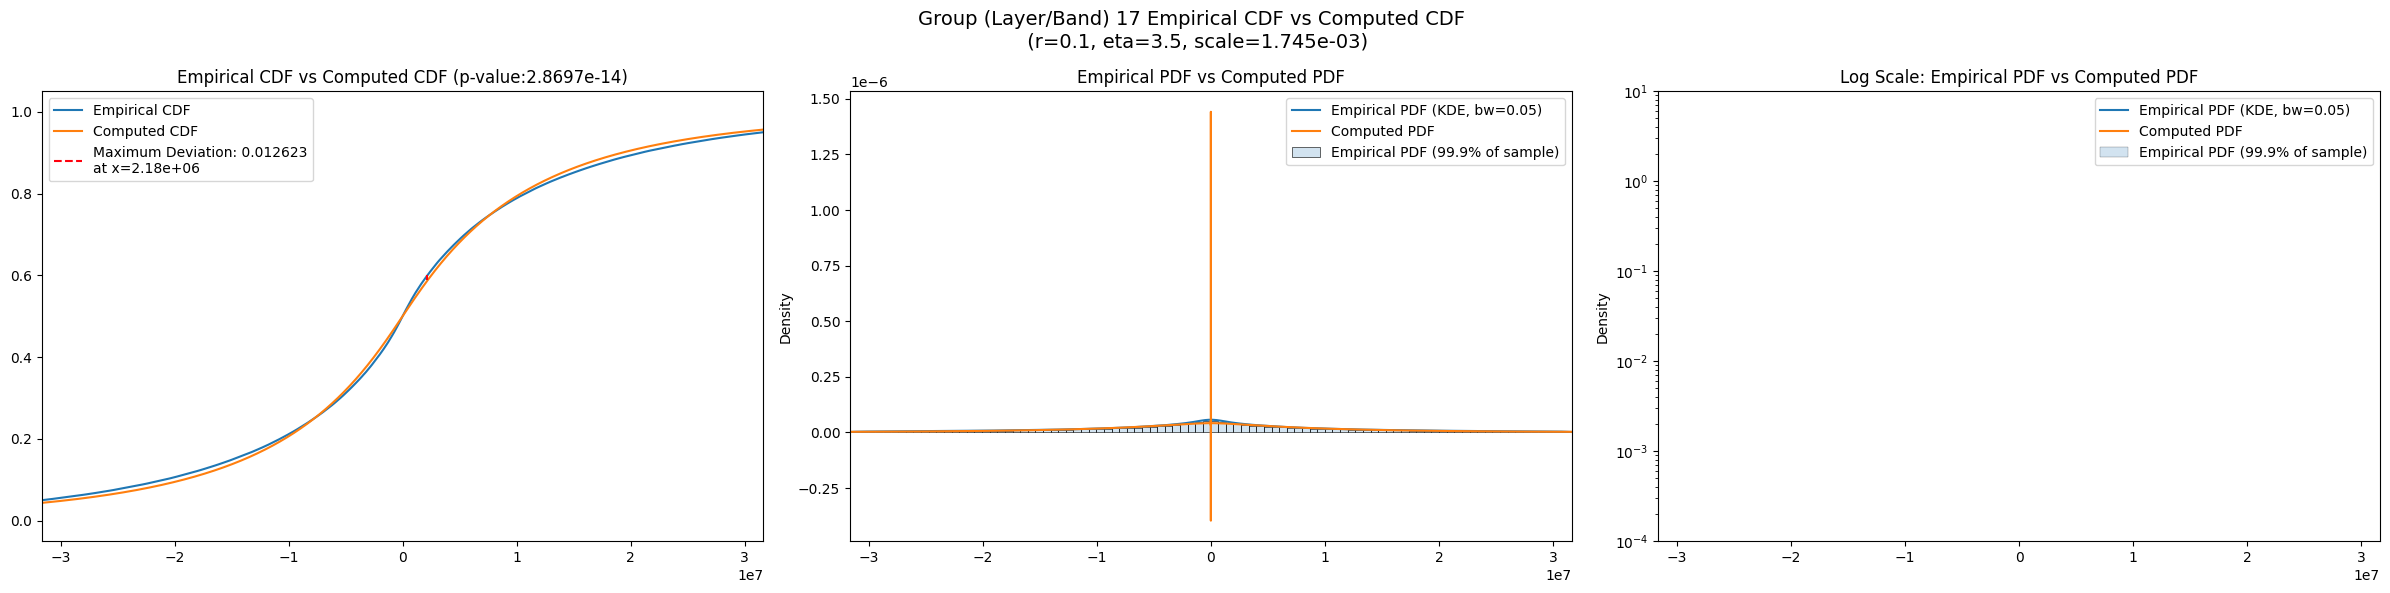

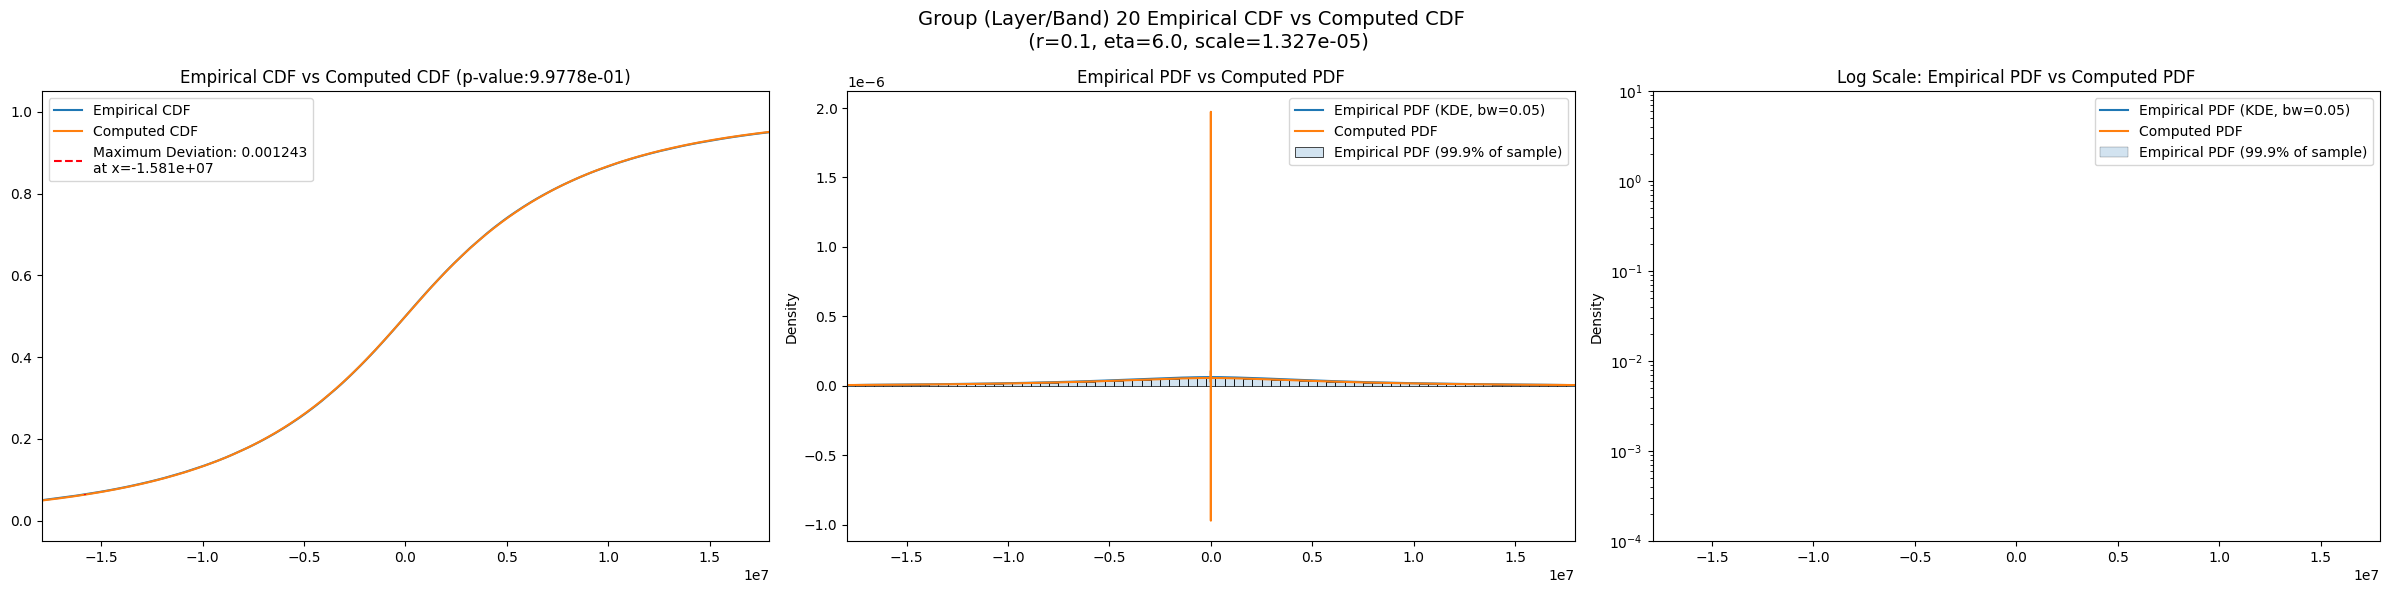

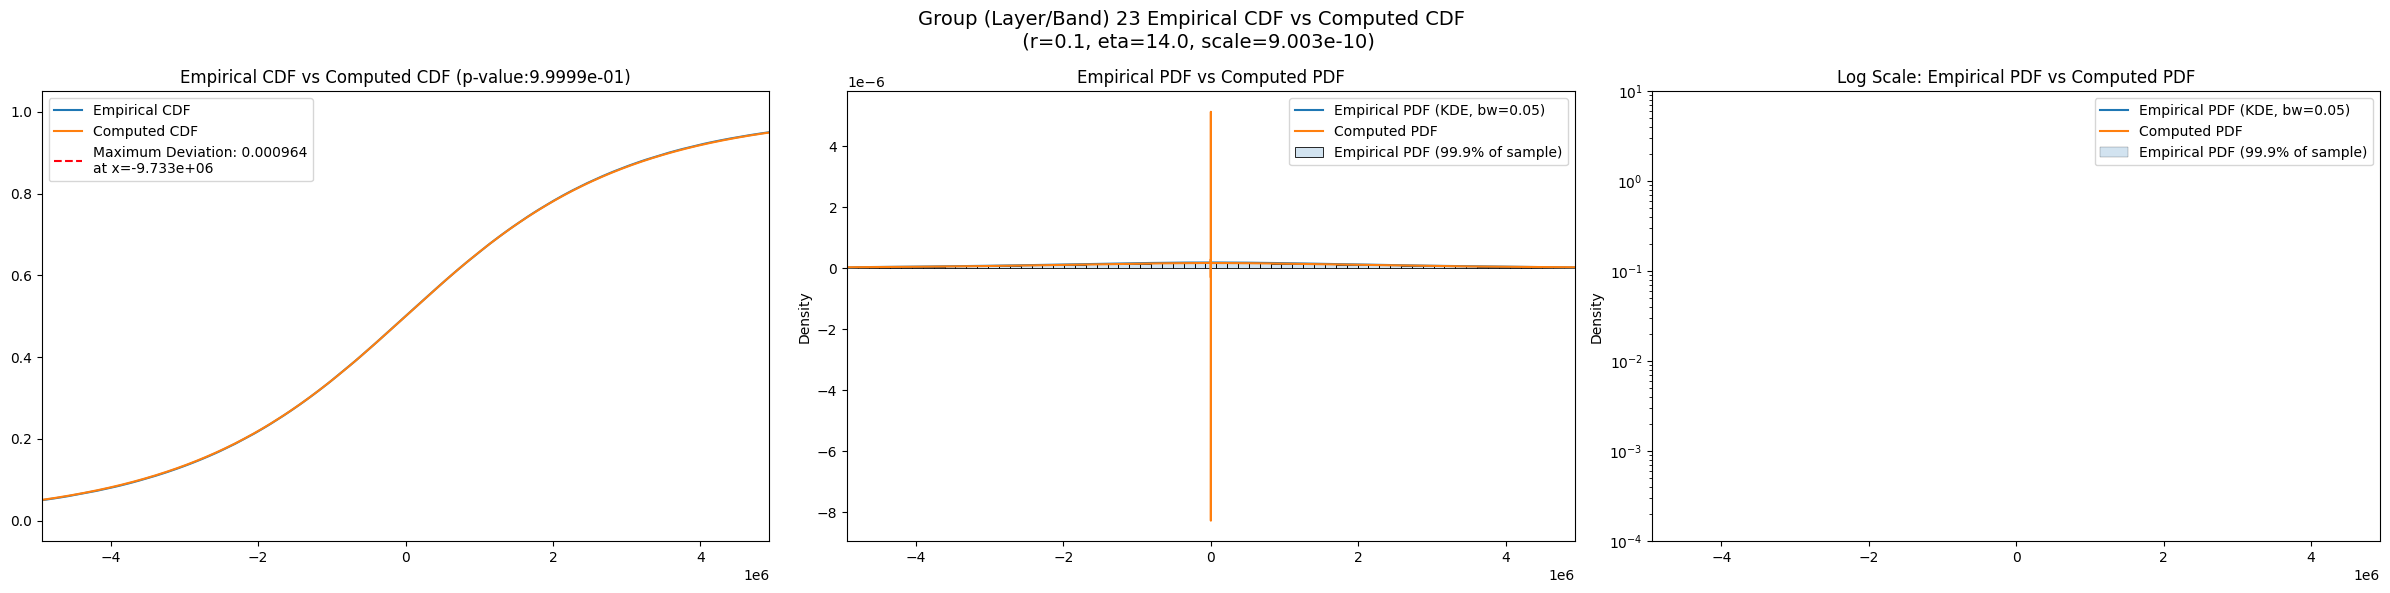

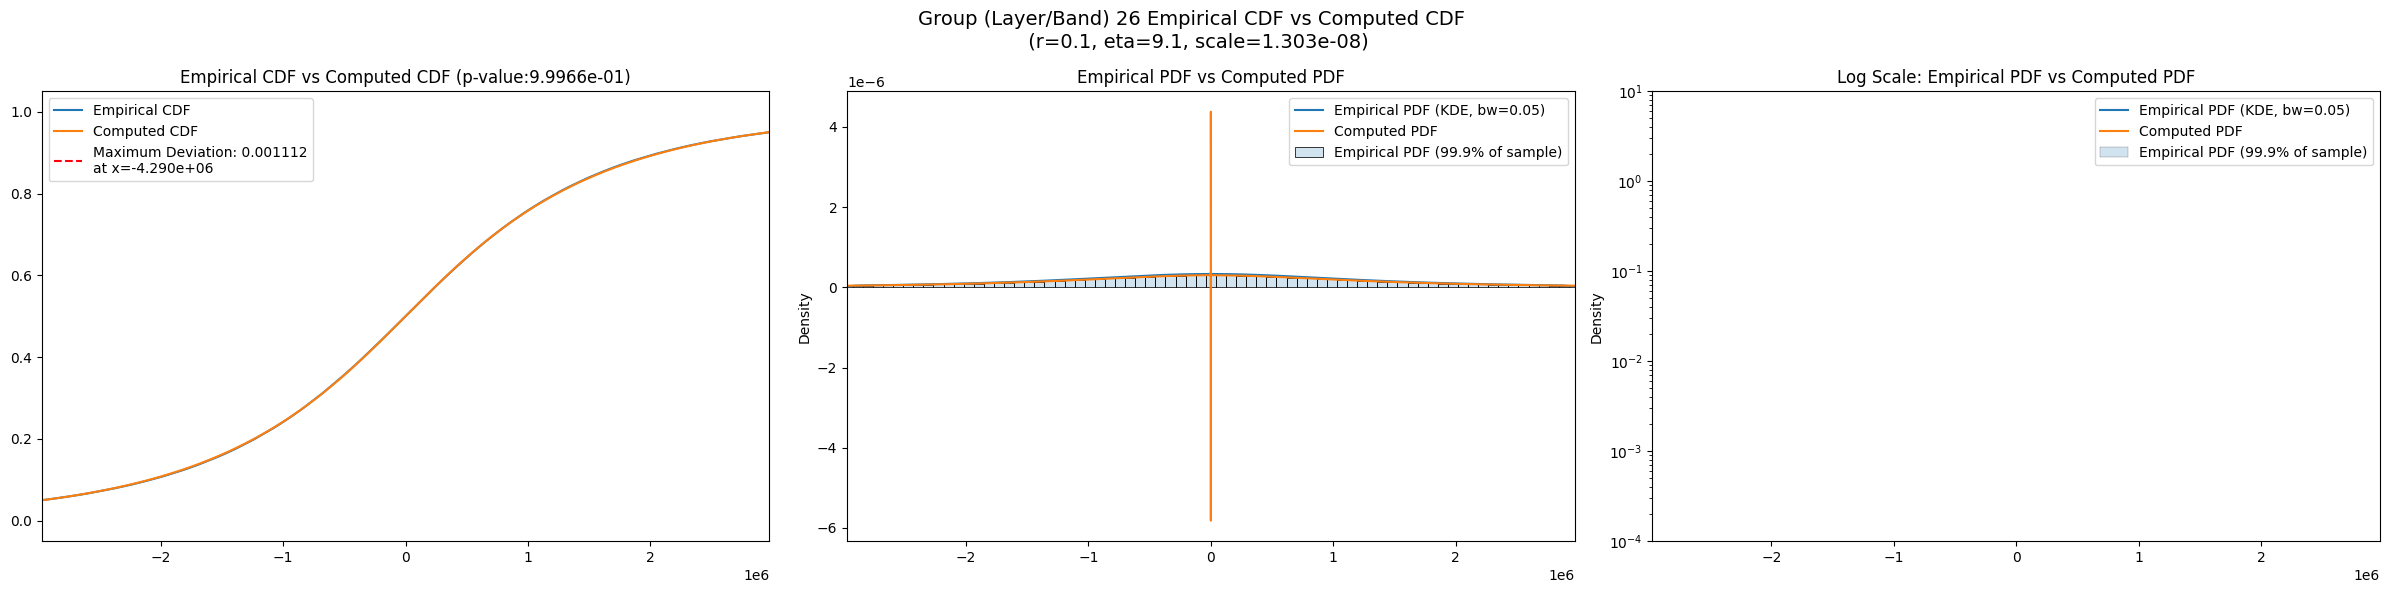

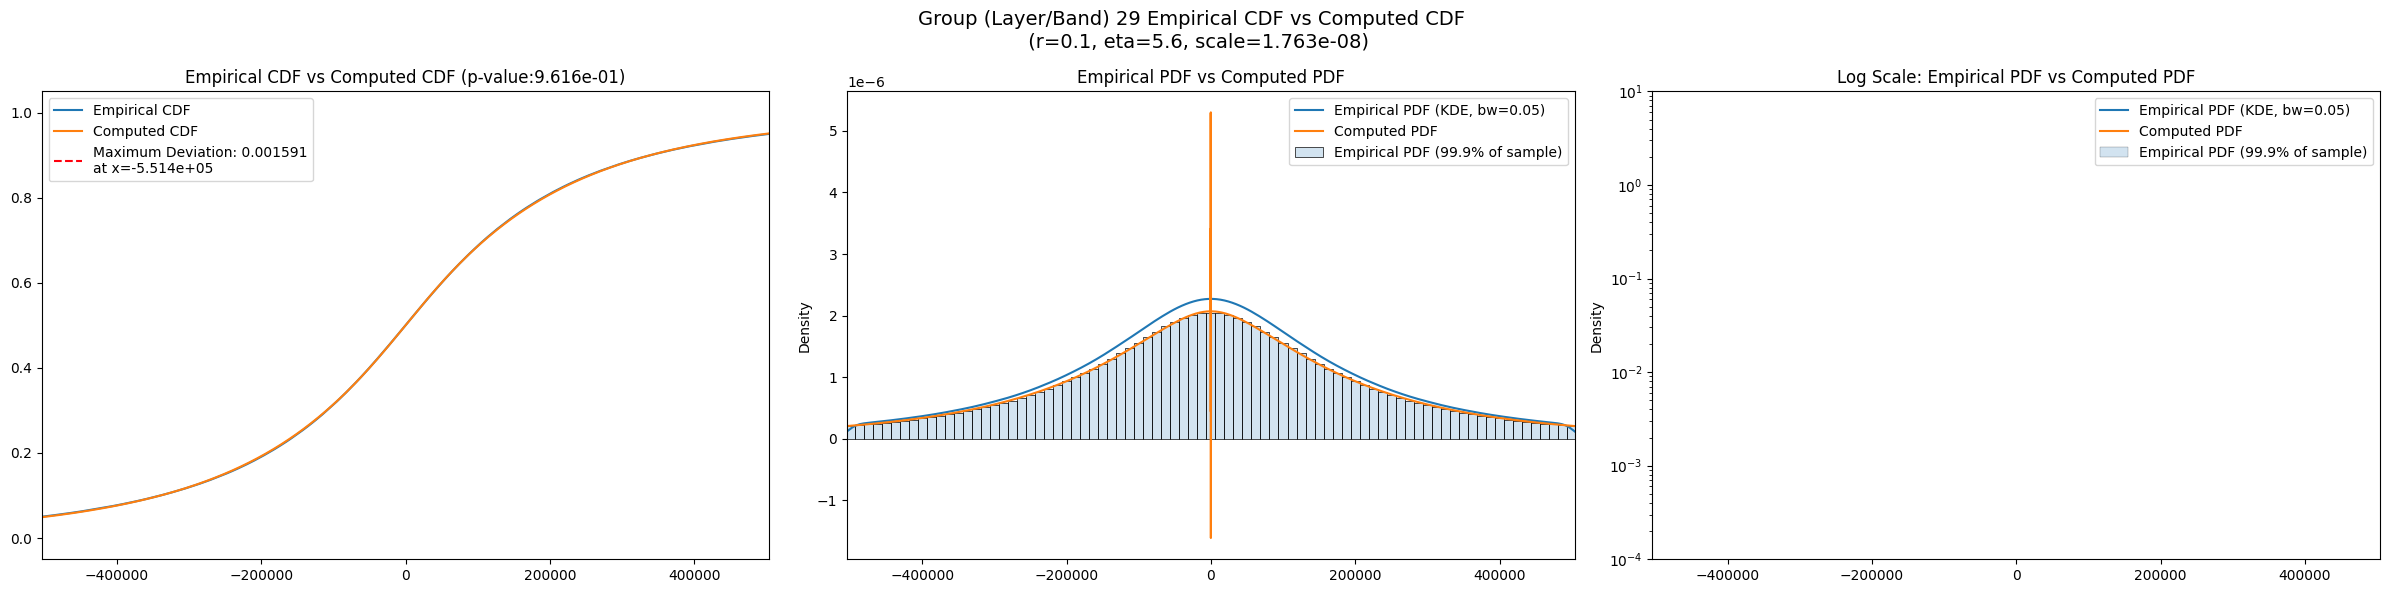

In [18]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [19]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [20]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,2.232949e+14,2.044359e+14,2.450234e+14,5.252033,2.206041,9.498203,2880.0,0.006436,0.1,13.0,...,1000000.0,0.415051,0.000000e+00,1000000.0,0.378354,0.000000e+00,1000000.0,0.354932,0.000000e+00,9.997225e-01
5,3.311355e+14,2.838907e+14,3.847795e+14,33.309539,24.537924,41.457803,8640.0,0.007794,0.1,7.7,...,1000000.0,0.397820,0.000000e+00,1000000.0,0.358948,0.000000e+00,1000000.0,0.335270,0.000000e+00,6.671666e-01
8,6.176871e+13,5.192469e+13,7.556703e+13,52.819935,16.010102,109.145743,24480.0,0.004622,0.2,14.0,...,1000000.0,0.341646,0.000000e+00,1000000.0,0.296598,0.000000e+00,1000000.0,0.272570,0.000000e+00,6.706719e-01
11,7.202464e+12,6.829576e+12,7.609443e+12,2.392278,1.164339,4.357608,67680.0,0.001391,0.2,20.0,...,1000000.0,0.203196,0.000000e+00,1000000.0,0.160902,0.000000e+00,1000000.0,0.135410,0.000000e+00,9.995517e-01
14,2.573510e+12,2.321575e+12,2.897079e+12,16.665702,5.415897,35.728051,100000.0,0.002342,0.2,6.9,...,1000000.0,0.059814,NaN,1000000.0,0.037300,2.546210e-121,942294.0,0.017024,1.326080e-25,6.735425e-01
17,3.977914e+14,3.692224e+14,4.292224e+14,6.408159,4.342514,10.709055,100000.0,0.012623,0.1,3.5,...,1000000.0,0.385319,0.000000e+00,1000000.0,0.347583,0.000000e+00,1000000.0,0.324031,0.000000e+00,2.869650e-14
20,1.329686e+14,1.237109e+14,1.432144e+14,5.945644,3.815722,12.027685,100000.0,0.001243,0.1,6.0,...,1000000.0,0.367705,0.000000e+00,1000000.0,0.325272,0.000000e+00,1000000.0,0.301335,0.000000e+00,9.977781e-01
23,1.013694e+13,9.443005e+12,1.103544e+13,6.997989,2.698813,24.278620,100000.0,0.000966,0.1,14.0,...,1000000.0,0.209324,0.000000e+00,1000000.0,0.165577,0.000000e+00,1000000.0,0.140495,0.000000e+00,9.999846e-01
26,3.622786e+12,3.391326e+12,3.881514e+12,4.820236,3.034605,10.719081,100000.0,0.001113,0.1,9.1,...,1000000.0,0.093963,0.000000e+00,1000000.0,0.058737,2.427670e-300,1000000.0,0.030325,2.528130e-80,9.996532e-01


## Results

In [21]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [22]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.006436,0.025248,0.006436,0.415051,0.378354,0.354932
5,0.007794,0.014591,0.007794,0.397820,0.358948,0.335270
8,0.004622,0.008673,0.004622,0.341646,0.296598,0.272570
11,0.001391,0.005218,0.001371,0.203196,0.160902,0.135410
14,0.002342,0.004293,0.002283,0.059814,0.037300,0.017024
17,0.012623,0.004293,0.012623,0.385319,0.347583,0.324031
20,0.001243,0.004293,0.001243,0.367705,0.325272,0.301335
23,0.000966,0.004293,0.000966,0.209324,0.165577,0.140495
26,0.001113,0.004293,0.001113,0.093963,0.058737,0.030325


In [23]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,2.232949e+14,0.006436,0.10,13.0,4.011148e-08,0.0
5,1.826525e+14,0.007794,0.10,7.7,2.619859e-06,75.0
8,3.966983e+13,0.004622,0.20,14.0,1.250168e+04,150.0
11,6.860580e+12,0.001371,0.21,20.0,1.684265e+03,75.0
14,2.193094e+12,0.002283,0.20,6.6,1.586047e+04,125.0
17,3.977914e+14,0.012623,0.10,3.5,1.744764e-03,0.0
20,1.329686e+14,0.001243,0.10,6.0,1.327136e-05,0.0
23,9.578502e+12,0.000966,0.10,14.0,9.003163e-10,50.0
26,3.525808e+12,0.001113,0.10,9.1,1.303479e-08,25.0
